In [2]:
# Analisis de datos
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

# Fechas y Horas
import time
from datetime import date
from datetime import timedelta

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Propiedas y visualizacion
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Alertas
import warnings
warnings.filterwarnings("ignore")
    
# Configuraciones
pd.set_option('float_format', '{:,.2f}'.format) #Ajusta formato de números
pd.set_option('display.max_columns', None) #Muestra todas la columnas
pd.set_option('display.max_colwidth', None) #Mostrar el NUM_IDENT completo

### 0. Parámetros y Funciones de apoyo

In [3]:
# Funciones de Apoyo
# Función para mostrar las frecuencias absolutas y relativas de un campo
def volumetria(df,columna,orden):
    resultado = df.groupby([columna]).agg(Cantidad=(columna, 'count')).reset_index()
    total = resultado['Cantidad'].sum()
    resultado['% Total'] = (resultado['Cantidad'] / total) * 100
    if orden == 0:
        resultado = resultado.sort_values('% Total', ascending=False)
    elif orden == 1:
        resultado = resultado.sort_values(columna, ascending=True)
    else:
        return print('En orden solo puede escoger los valores 0,1')
    
    # Calcular el % Total Acumulado
    resultado['% Acumulado'] = resultado['% Total'].cumsum()
    return resultado

# Revision de Missings
def revision_missings(df):
    df_missings = pd.DataFrame({
        'COLUMNA': df.columns,
        'NRO_NULL': df.isna().sum(),
        '%_NULL': round(df.isna().mean() * 100, 2).astype(str) + '%'
    }).reset_index(drop=True)

    return df_missings

# Revision de Outliers General
def outliers_col(df):
    resultados = []
    for columna in df:
        if df[columna].dtype != object:
            q1 = stats.scoreatpercentile(df[columna].dropna(), 25)
            q3 = stats.scoreatpercentile(df[columna].dropna(), 75)
            iqr = q3 - q1
            lim_inf = q1 - 1.5 * iqr
            lim_sup = q3 + 1.5 * iqr
            n_outliers_inf = len(df[(df[columna] < lim_inf)])
            n_outliers_sup = len(df[(df[columna] > lim_sup)])
            resultados.append([df[columna].name, n_outliers_inf, n_outliers_sup])
    
    df_resultados = pd.DataFrame(resultados, columns=['NOMBRE_COLUMNA', 'NRO_OUTLIERS_INF', 'NRO_OUTLIERS_SUP'])
    return df_resultados

# Revision de Outliers Individual
def rev_outliers(df,campo):
    cantidad = df[campo].count()
    nulls = df[campo].isna().sum()
    unicos = df[campo].nunique()
    porc_nulls = round(nulls/ df.shape[0],4)*100
    print(f'Nro Filas: {cantidad:,}.')
    print(f'Nro Nulls: {nulls:,}. Un {porc_nulls}% son nulls.')
    print(f'Nro Valores Unicos: {unicos:,}.')

    print(f'\nDeciles de {campo}:')
    print(df[campo].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]))

    # Calcular los límites utilizando el rango intercuartílico (IQR)
    q1 = df[campo].quantile(0.25)
    q3 = df[campo].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    print(f'\nLímite superior: {round(upper_limit,2)} y Límite inferior: {round(lower_limit,2)}')
    print(f'Valor mínimo: {df[campo].min()}')
    print(f'Valor máximo: {df[campo].max()}')

    # Identificar los valores atípicos
    outliers = df[(df[campo] < lower_limit) | (df[campo] > upper_limit)]
    # Calcular la cantidad de outliers
    print(f'\nCantidad de outliers: {outliers.shape[0]} de {df.shape[0]}. Es un {round(outliers.shape[0]/df.shape[0],2)*100}%.')

    # Graficar el boxplot
    sns.boxplot(x=df[campo])
    # Agregar título al gráfico
    plt.title('Boxplot de '+campo)
    # Mostrar el gráfico
    plt.show()

def visualizar_kde(df, excluir_columnas, num_columnas=3, figsize=(15, 5)):
    # Filtrar las columnas que no están en la lista de exclusión
    columnas = df.drop(columns=excluir_columnas).columns

    # Definir el número de filas basado en las columnas
    num_filas = math.ceil(len(columnas) / num_columnas)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(figsize[0], num_filas * figsize[1]))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Iterar sobre cada columna y graficar en cada subgráfico
    for i, col in enumerate(columnas):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')

    # Eliminar cualquier gráfico vacío si el número de columnas no es múltiplo exacto de filas * columnas
    for i in range(len(columnas), len(axes)):
        fig.delaxes(axes[i])

    # Ajustar el espacio entre los gráficos
    plt.tight_layout()
    plt.show()

# Función para limitar por la izquierda
def limitar_por_izquierda(df, columna, limite_inferior):
    df[columna][df[columna] < df[columna].quantile(limite_inferior)] = df[columna].quantile(limite_inferior)
    return df

# Función para limitar por la derecha
def limitar_por_derecha(df, columna, limite_superior):
    df[columna][df[columna] > df[columna].quantile(limite_superior)] = df[columna].quantile(limite_superior)
    return df

### 1. Importacion Data

In [33]:
directory_consolidado = 'C:/Users/BW439WF/Downloads/Datathon DMC/Datathon_DMC/data/03_interim/'
df_consolidado = pd.read_parquet(directory_consolidado + 'vars_compromisos_1.parquet')
# Resumen Data
#print(f'Nro Clientes: {df_consolidado["COD_CLIENTE"].nunique():,}')
print(f'Nro Filas: {df_consolidado.shape[0]:,}')
df_consolidado.head()

Nro Filas: 37,577


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,FECHA_ESTABLECIDA,TIPO_COMPROMISO,TIPO_REGISTRO,FRECUENCIA,MEDIO_PAGO,ENTIDAD_COBRADORA,TIPO_CUENTA,TIPO_TARJETA,BANCO_EMISOR,CANAL_CAMPANA,CODIGO_AUDITORIA,CAMPANA_ACTIVIDAD,CAMPANA_FIDELIZACION,CODIGO_UBICACION,PUNTO_CAPTACION,TIPO_BAJA,MOTIVO_BAJA
0,003UX00000I33INYAZ,0.00,0,0,0,10.00,10.00,10.00,10.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F02,F2F CHICLAYO IF4C 2025,NaN,NaN,RIPLEY PIURA,NaN,NaN
1,003UX00000I33AHYAZ,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,1,25,2025-04-30,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Interbank,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,PLAZA VEA LA BOLICHERA,NaN,NaN
2,003UX00000I2y49YAB,0.00,0,0,0,10.00,10.00,10.00,10.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Scotiabank,Ahorros,NaN,NaN,F2F,RF-F2F02,F2F CHICLAYO IF4C 2025,NaN,NaN,RIPLEY PIURA,NaN,NaN
3,003UX00000I2xssYAB,0.00,0,0,0,30.00,30.00,30.00,30.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-03-31,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Débito,NaN,NaN,Visa Débito,INTERBANK,Telemarketing,AF7.1RETMK,TELEMARKETING 2025,NaN,Lima,BASE - 102,NaN,NaN
4,003UX00000I2tECYAZ,0.00,0,0,0,100.00,100.00,100.00,100.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-25,Primer Compromiso,PI - Padrinazgo individual,Mensual,Débito Automático,Banco de Crédito del Perú,Ahorros,NaN,NaN,Telemarketing,AF7.1RETMK,TELEMARKETING 2025,NaN,Lima,BASE - 104,NaN,NaN


In [27]:
import unidecode  # Asegura que tienes instalada esta librería con: pip install unidecode
directory_contactos = "C:/Users/BW439WF/Downloads/Datathon DMC/Datathon_DMC/data/02_raw/"
df_contactos = pd.read_excel(directory_contactos + 'BBDD_CONTACTOS.xlsx')

# Función para limpiar nombres de columnas
def clean_column_names(columns):
    return [unidecode.unidecode(col.upper().replace(" ", "_")) for col in columns]

# Aplicar la función a las columnas del DataFrame
df_contactos.columns = clean_column_names(df_contactos.columns)

# Resumen Data
print(f'Nro Clientes: {df_contactos["ID_COMPLETO"].nunique():,}')
print(f'Nro Filas: {df_contactos.shape[0]:,}')
df_contactos.head()

Nro Clientes: 147,513
Nro Filas: 147,513


,ID_COMPLETO,PAIS_DE_CORREO,ESTADO_O_PROVINCIA_DE_CORREO,CODIGO_POSTAL_DE_CORREO,CIUDAD_DE_CORREO,NOMBRE,GENERO,TRATAMIENTO,ESTADO_CIVIL,TIENE_HIJOS,HOBBIE,TIENE_NIETOS,NIVEL_DE_ESTUDIOS,TRABAJA_ACTUALMENTE,OCUPACION
0,0031R00001uhz7IQAQ,Perú,Lima,Lima,San Borja,Gledy Georgina,Femenino,Srita.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0031R0000281tkvQAA,Perú,Lima,Lima,San Borja,Fredy Enrique,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0031R00002KqNYbQAN,Perú,Lima,Lima,Santiago De Surco,Alvaro Patricio,Masculino,Sr.,Soltero/a?,No,NaN,NaN,NaN,NaN,NaN
3,0031R00002hJzb5QAC,Perú,Lambayeque,Chiclayo,Chiclayo,Anton Cesar,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0033600001ADzauAAD,Perú,Lima,Lima,Comas,Diana Alison Milagros,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_consolidado_final = df_consolidado.merge(df_contactos, how='inner', left_on=['CONTACTO_ID_COMPLETO'], right_on=['ID_COMPLETO'])

# Resumen Data
print(f'Nro Clientes: {df_consolidado_final["ID_COMPLETO"].nunique():,}')
print(f'Nro Filas: {df_consolidado_final.shape[0]:,}')
df_consolidado_final.head()

Nro Clientes: 37,572
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,FECHA_ESTABLECIDA,TIPO_COMPROMISO,TIPO_REGISTRO,FRECUENCIA,MEDIO_PAGO,ENTIDAD_COBRADORA,TIPO_CUENTA,TIPO_TARJETA,BANCO_EMISOR,CANAL_CAMPANA,CODIGO_AUDITORIA,CAMPANA_ACTIVIDAD,CAMPANA_FIDELIZACION,CODIGO_UBICACION,PUNTO_CAPTACION,TIPO_BAJA,MOTIVO_BAJA,ID_COMPLETO,PAIS_DE_CORREO,ESTADO_O_PROVINCIA_DE_CORREO,CODIGO_POSTAL_DE_CORREO,CIUDAD_DE_CORREO,NOMBRE,GENERO,TRATAMIENTO,ESTADO_CIVIL,TIENE_HIJOS,HOBBIE,TIENE_NIETOS,NIVEL_DE_ESTUDIOS,TRABAJA_ACTUALMENTE,OCUPACION
0,003UX00000I2dSlYAJ,0.00,0,0,0,5.00,5.00,5.00,5.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,PLAZA VEA CENTRO CIVICO,NaN,NaN,003UX00000I2dSlYAJ,Perú,NaN,NaN,NaN,Indhira,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,003UX00000I2bSXYAZ,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2bSXYAZ,Perú,Loreto,NaN,NaN,Emilia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,003UX00000I2VWpYAN,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Banco de Crédito del Perú,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2VWpYAN,Perú,NaN,NaN,NaN,Brendia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,003UX00000I2VWoYAN,0.00,0,0,0,30.00,30.00,30.00,30.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-03-03,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Interbank,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2VWoYAN,Perú,Loreto,NaN,NaN,Jhon,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,003UX00000I2PGCYA3,0.00,0,0,0,30.00,30.00,30.00,30.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2PGCYA3,Perú,NaN,NaN,NaN,Cristhoper,Masculino,Sr.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_consolidado_final.to_csv('vars_compromisos_2.csv', sep=";", index=False, encoding='LATIN-1')

### 3. Preprocesamiento de data

In [46]:
# Resumen Data
#print(f'Nro Clientes: {df_consolidado_final["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_consolidado_final.shape[1]:,}')
print(f'Nro Filas: {df_consolidado_final.shape[0]:,}')
df_consolidado_final.head(3)

Nro Columnas: 61
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,FECHA_ESTABLECIDA,TIPO_COMPROMISO,TIPO_REGISTRO,FRECUENCIA,MEDIO_PAGO,ENTIDAD_COBRADORA,TIPO_CUENTA,TIPO_TARJETA,BANCO_EMISOR,CANAL_CAMPANA,CODIGO_AUDITORIA,CAMPANA_ACTIVIDAD,CAMPANA_FIDELIZACION,CODIGO_UBICACION,PUNTO_CAPTACION,TIPO_BAJA,MOTIVO_BAJA,ID_COMPLETO,PAIS_DE_CORREO,ESTADO_O_PROVINCIA_DE_CORREO,CODIGO_POSTAL_DE_CORREO,CIUDAD_DE_CORREO,NOMBRE,GENERO,TRATAMIENTO,ESTADO_CIVIL,TIENE_HIJOS,HOBBIE,TIENE_NIETOS,NIVEL_DE_ESTUDIOS,TRABAJA_ACTUALMENTE,OCUPACION
0,003UX00000I2dSlYAJ,0.00,0,0,0,5.00,5.00,5.00,5.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,PLAZA VEA CENTRO CIVICO,NaN,NaN,003UX00000I2dSlYAJ,Perú,NaN,NaN,NaN,Indhira,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,003UX00000I2bSXYAZ,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Tarjeta de Crédito,NaN,NaN,Otros,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2bSXYAZ,Perú,Loreto,NaN,NaN,Emilia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,003UX00000I2VWpYAN,0.00,0,0,0,20.00,20.00,20.00,20.00,6.00,6.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,0,1,25,2025-02-19,Primer Compromiso,DI - Regular,Mensual,Débito Automático,Banco de Crédito del Perú,Ahorros,NaN,NaN,F2F,RF-F2F01,F2F CLASICO LIMA 2025,NaN,NaN,MALL AVENTURA IQUITOS,NaN,NaN,003UX00000I2VWpYAN,Perú,NaN,NaN,NaN,Brendia,Femenino,Sra.,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_consolidado_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37572 entries, 0 to 37571
Data columns (total 61 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   CONTACTO_ID_COMPLETO                       37572 non-null  object  
 1   TOTAL_DONADO                               37572 non-null  float64 
 2   CANTIDAD_CUOTAS_PAGADAS_GLOBAL             37572 non-null  int64   
 3   DONANTE_ACTIVO                             37572 non-null  int64   
 4   COMPROMISO_ACTIVO                          37572 non-null  int64   
 5   IMPORTE_DONACION_PROM_6M                   21080 non-null  float64 
 6   IMPORTE_DONACION_PROM_9M                   21080 non-null  float64 
 7   IMPORTE_DONACION_PROM_12M                  21080 non-null  float64 
 8   IMPORTE_DONACION_PROM_24M                  21080 non-null  float64 
 9   CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M   21080 non-null  float64 
 10  CANTIDAD_D

In [ ]:
 0   CONTACTO_ID_COMPLETO                       37572 non-null  object  
 1   TOTAL_DONADO                               37572 non-null  float64 
 2   CANTIDAD_CUOTAS_PAGADAS_GLOBAL             37572 non-null  int64   
 3   DONANTE_ACTIVO                             37572 non-null  int64   
 4   COMPROMISO_ACTIVO                          37572 non-null  int64   
 5   IMPORTE_DONACION_PROM_6M                   21080 non-null  float64 
 6   IMPORTE_DONACION_PROM_9M                   21080 non-null  float64 
 7   IMPORTE_DONACION_PROM_12M                  21080 non-null  float64 
 8   IMPORTE_DONACION_PROM_24M                  21080 non-null  float64 
 9   CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M   21080 non-null  float64 
 10  CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M   21080 non-null  float64 
 11  CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M  21080 non-null  float64 
 12  CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M  21080 non-null  float64 
 13  NUMERO_CUOTAS_PROM_6M                      21080 non-null  float64 
 14  NUMERO_CUOTAS_PROM_9M                      21080 non-null  float64 
 15  NUMERO_CUOTAS_PROM_12M                     21080 non-null  float64 
 16  NUMERO_CUOTAS_PROM_24M                     21080 non-null  float64 
 17  CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M     21080 non-null  float64 
 18  CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M     21080 non-null  float64 
 19  CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M    21080 non-null  float64 
 20  CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M    21080 non-null  float64 
 21  DONANTE_ACTIVO_right                       37572 non-null  int64   
 22  RECENCIA_DONACION                          31903 non-null  float64 
 23  ANTIGUEDAD_PRIMER_PAGO                     31034 non-null  float64 
 24  ANTIGUEDAD_PRIMER_DONACION                 31903 non-null  float64 
 25  DIFERENCIA_PRIMER_ULTIMO_PAGO              31903 non-null  float64 
 26  NUM_BAJAS                                  37572 non-null  uint32  
 27  NUM_FECHAS_ESTABLECIDAS                    37572 non-null  uint32  
 28  ANTIGUEDAD_DIAS                            37572 non-null  int64   
 29  FECHA_ESTABLECIDA                          37572 non-null  object  
 TIPO_COMPROMISO                            37572 non-null  category
 TIPO_REGISTRO                              37572 non-null  category
 FRECUENCIA                                 37572 non-null  category
 MEDIO_PAGO                                 37572 non-null  category
 ENTIDAD_COBRADORA                          16392 non-null  category
 TIPO_CUENTA                                16337 non-null  category
 TIPO_TARJETA                               20738 non-null  category
 BANCO_EMISOR                               19461 non-null  category
 CANAL_CAMPANA                              37572 non-null  category
 CODIGO_AUDITORIA                           37567 non-null  category
 CAMPANA_ACTIVIDAD                          37572 non-null  category
 CAMPANA_FIDELIZACION                       1787 non-null   category
 CODIGO_UBICACION                           37563 non-null  category
 PUNTO_CAPTACION                            37571 non-null  category
 TIPO_BAJA                                  8796 non-null   category
 MOTIVO_BAJA                                8796 non-null   category
 ID_COMPLETO                                37572 non-null  object  
 PAIS_DE_CORREO                             37270 non-null  object  
 ESTADO_O_PROVINCIA_DE_CORREO               35990 non-null  object  
 CODIGO_POSTAL_DE_CORREO                    34703 non-null  object  
 CIUDAD_DE_CORREO                           34672 non-null  object  
 NOMBRE                                     37572 non-null  object  
 GENERO                                     37563 non-null  object  
 TRATAMIENTO                                37537 non-null  object  
 ESTADO_CIVIL                               9051 non-null   object  
 TIENE_HIJOS                                10558 non-null  object  
 HOBBIE                                     371 non-null    object  
 TIENE_NIETOS                               43 non-null     object  
 NIVEL_DE_ESTUDIOS                          291 non-null    object  
 TRABAJA_ACTUALMENTE                        721 non-null    object  
 OCUPACION                                  19171 non-null  object  

#### 03.1. Correlacion

In [75]:
revision_missings(df_consolidado_final).head(10)

,COLUMNA,NRO_NULL,%_NULL
0,CONTACTO_ID_COMPLETO,0,0.0%
1,TOTAL_DONADO,0,0.0%
2,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,0,0.0%
3,DONANTE_ACTIVO,0,0.0%
4,COMPROMISO_ACTIVO,0,0.0%
5,IMPORTE_DONACION_PROM_6M,16492,43.89%
6,IMPORTE_DONACION_PROM_9M,16492,43.89%
7,IMPORTE_DONACION_PROM_12M,16492,43.89%
8,IMPORTE_DONACION_PROM_24M,16492,43.89%
9,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,16492,43.89%


In [56]:
revision_missings(df_consolidado_final).tail(31)

,COLUMNA,NRO_NULL,%_NULL
30,TIPO_COMPROMISO,0,0.0%
31,TIPO_REGISTRO,0,0.0%
32,FRECUENCIA,0,0.0%
33,MEDIO_PAGO,0,0.0%
34,ENTIDAD_COBRADORA,21180,56.37%
35,TIPO_CUENTA,21235,56.52%
36,TIPO_TARJETA,16834,44.8%
37,BANCO_EMISOR,18111,48.2%
38,CANAL_CAMPANA,0,0.0%
39,CODIGO_AUDITORIA,5,0.01%


In [53]:
lista_excluir = ['CONTACTO_ID_COMPLETO', 'TIPO_COMPROMISO', 'TIPO_REGISTRO', 'FRECUENCIA', 'MEDIO_PAGO', 'ENTIDAD_COBRADORA', 'TIPO_CUENTA', 'TIPO_TARJETA', 'BANCO_EMISOR', 'CANAL_CAMPANA', 'CODIGO_AUDITORIA', 'CAMPANA_ACTIVIDAD', 'CAMPANA_FIDELIZACION', 'CODIGO_UBICACION', 'PUNTO_CAPTACION', 'TIPO_BAJA', 'MOTIVO_BAJA', 'ID_COMPLETO', 'PAIS_DE_CORREO', 'ESTADO_O_PROVINCIA_DE_CORREO', 'CODIGO_POSTAL_DE_CORREO', 'CIUDAD_DE_CORREO', 'NOMBRE', 'GENERO', 'TRATAMIENTO', 'ESTADO_CIVIL', 'TIENE_HIJOS', 'HOBBIE', 'TIENE_NIETOS', 'NIVEL_DE_ESTUDIOS', 'TRABAJA_ACTUALMENTE', 'OCUPACION', 'FECHA_ESTABLECIDA']
# Matriz de correlaciones
corr_matrix = df_consolidado_final.drop(columns=lista_excluir).corr(method='pearson')
corr_matrix

,TOTAL_DONADO,CANTIDAD_CUOTAS_PAGADAS_GLOBAL,DONANTE_ACTIVO,COMPROMISO_ACTIVO,IMPORTE_DONACION_PROM_6M,IMPORTE_DONACION_PROM_9M,IMPORTE_DONACION_PROM_12M,IMPORTE_DONACION_PROM_24M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M,NUMERO_CUOTAS_PROM_6M,NUMERO_CUOTAS_PROM_9M,NUMERO_CUOTAS_PROM_12M,NUMERO_CUOTAS_PROM_24M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M,DONANTE_ACTIVO_right,RECENCIA_DONACION,ANTIGUEDAD_PRIMER_PAGO,ANTIGUEDAD_PRIMER_DONACION,DIFERENCIA_PRIMER_ULTIMO_PAGO,NUM_BAJAS,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
TOTAL_DONADO,1.00,0.67,0.35,0.35,0.04,0.08,0.20,0.28,-0.11,-0.09,-0.04,0.22,0.01,0.00,-0.00,-0.01,0.20,0.27,0.42,0.64,0.35,-0.28,0.29,0.32,0.56,0.03,0.22,0.42
CANTIDAD_CUOTAS_PAGADAS_GLOBAL,0.67,1.00,0.51,0.51,-0.09,-0.08,-0.08,-0.00,-0.19,-0.17,-0.11,0.44,0.03,0.03,0.04,0.05,0.29,0.38,0.52,1.00,0.51,-0.41,0.56,0.59,0.93,0.02,0.28,0.69
DONANTE_ACTIVO,0.35,0.51,1.00,0.99,0.04,0.05,0.05,-0.03,0.18,0.26,0.29,0.22,0.03,0.02,-0.00,-0.13,0.18,0.26,0.31,0.45,1.00,-0.80,-0.31,-0.27,0.45,-0.25,0.14,0.17
COMPROMISO_ACTIVO,0.35,0.51,0.99,1.00,0.03,0.04,0.04,-0.03,0.17,0.25,0.29,0.23,0.02,0.02,-0.00,-0.13,0.17,0.25,0.30,0.45,0.99,-0.79,-0.30,-0.25,0.45,-0.27,0.12,0.18
IMPORTE_DONACION_PROM_6M,0.04,-0.09,0.04,0.03,1.00,0.82,0.74,0.46,0.38,0.21,0.10,-0.21,0.07,0.04,0.02,-0.01,0.20,0.12,0.06,-0.09,0.04,-0.11,-0.28,-0.15,-0.08,0.01,0.03,-0.13
IMPORTE_DONACION_PROM_9M,0.08,-0.08,0.05,0.04,0.82,1.00,0.89,0.53,0.26,0.34,0.18,-0.24,0.05,0.06,0.03,-0.02,0.14,0.21,0.12,-0.08,0.05,-0.13,-0.26,-0.17,-0.08,0.02,0.04,-0.13
IMPORTE_DONACION_PROM_12M,0.20,-0.08,0.05,0.04,0.74,0.89,1.00,0.58,0.18,0.23,0.32,-0.25,0.03,0.04,0.04,-0.02,0.10,0.15,0.19,-0.08,0.05,-0.13,-0.26,-0.17,-0.08,0.03,0.05,-0.13
IMPORTE_DONACION_PROM_24M,0.28,-0.00,-0.03,-0.03,0.46,0.53,0.58,1.00,-0.02,-0.02,-0.01,-0.05,-0.00,-0.00,-0.01,-0.02,0.00,0.01,0.02,-0.00,-0.03,0.03,0.01,0.01,-0.01,0.04,0.02,-0.00
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M,-0.11,-0.19,0.18,0.17,0.38,0.26,0.18,-0.02,1.00,0.58,0.30,-0.42,0.17,0.10,0.05,-0.03,0.47,0.28,0.14,-0.19,0.18,-0.29,-0.38,-0.39,-0.21,-0.04,0.06,-0.28
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M,-0.09,-0.17,0.26,0.25,0.21,0.34,0.23,-0.02,0.58,1.00,0.59,-0.40,0.10,0.12,0.06,-0.05,0.27,0.50,0.29,-0.17,0.26,-0.35,-0.42,-0.43,-0.20,-0.08,0.06,-0.26


Nro variables: 60


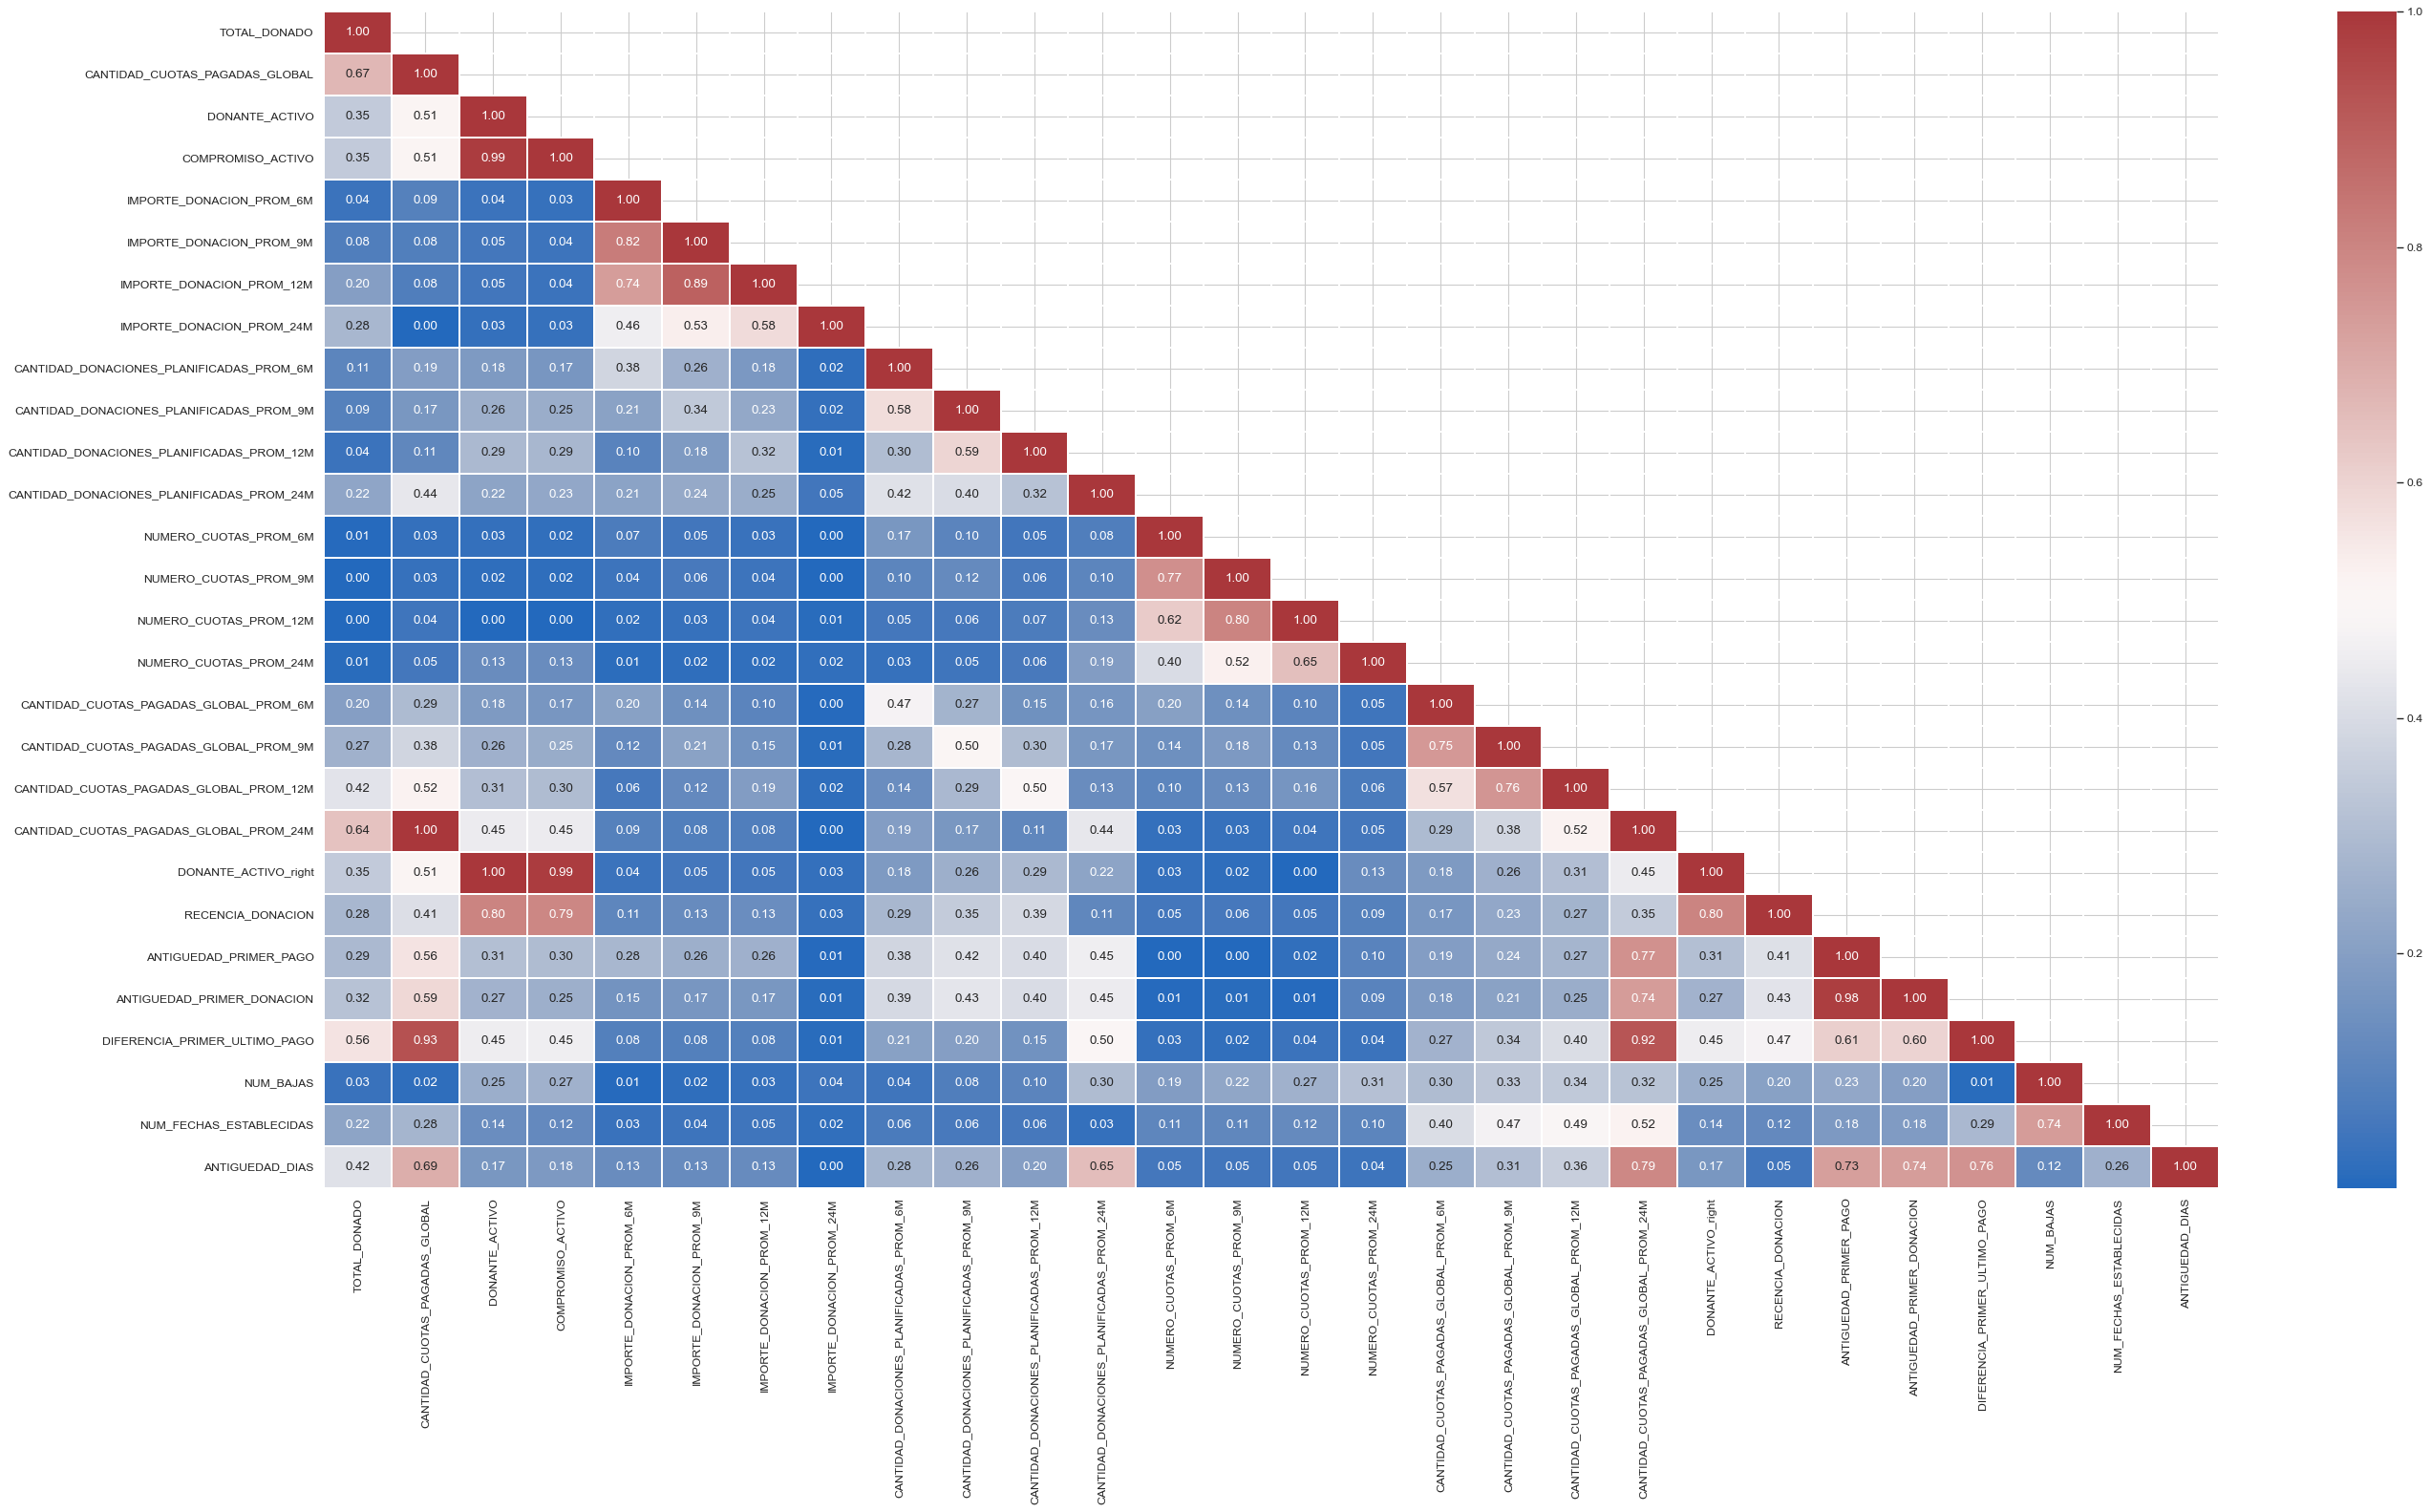

In [54]:
print(f"Nro variables: {df_consolidado_final.shape[1] - 1}")
corr = df_consolidado_final.drop(columns=lista_excluir).corr(method='pearson').abs()

# Creamos una mascara para ver la correlacion en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# Mostramos la matriz de correlacion
plt.figure(figsize=(40,20), dpi = 80)
sns.heatmap(corr, mask = mask, annot=True, cmap='vlag', fmt='.2f', linewidths=0.2)
plt.show()

In [57]:
df_consolidado_final.columns

Index(['CONTACTO_ID_COMPLETO', 'TOTAL_DONADO',
       'CANTIDAD_CUOTAS_PAGADAS_GLOBAL', 'DONANTE_ACTIVO', 'COMPROMISO_ACTIVO',
       'IMPORTE_DONACION_PROM_6M', 'IMPORTE_DONACION_PROM_9M',
       'IMPORTE_DONACION_PROM_12M', 'IMPORTE_DONACION_PROM_24M',
       'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M',
       'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M',
       'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M',
       'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M', 'NUMERO_CUOTAS_PROM_6M',
       'NUMERO_CUOTAS_PROM_9M', 'NUMERO_CUOTAS_PROM_12M',
       'NUMERO_CUOTAS_PROM_24M', 'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M',
       'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M',
       'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M',
       'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M', 'DONANTE_ACTIVO_right',
       'RECENCIA_DONACION', 'ANTIGUEDAD_PRIMER_PAGO',
       'ANTIGUEDAD_PRIMER_DONACION', 'DIFERENCIA_PRIMER_ULTIMO_PAGO',
       'NUM_BAJAS', 'NUM_FECHAS_ESTABLECIDAS', 'ANTIGUEDAD_DIAS',
       'FECHA_ESTA

In [224]:
lista_variables = [
    'CONTACTO_ID_COMPLETO', 
    'TOTAL_DONADO', #OPC1
    #'CANTIDAD_CUOTAS_PAGADAS_GLOBAL', #OPC1
    #'DONANTE_ACTIVO', FLAG
    #'COMPROMISO_ACTIVO', FLAG
    #'IMPORTE_DONACION_PROM_6M', #Comportamental
    #'IMPORTE_DONACION_PROM_9M',
    'IMPORTE_DONACION_PROM_12M', 
    #'IMPORTE_DONACION_PROM_24M',
    #'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_6M', #Comportamental
    #'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_9M',
    'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M',
    #'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_24M', 
    #'NUMERO_CUOTAS_PROM_6M', #Comportamental
    #'NUMERO_CUOTAS_PROM_9M', 
    'NUMERO_CUOTAS_PROM_12M',
    #'NUMERO_CUOTAS_PROM_24M', 
    #'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_6M', #Comportamental
    #'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_9M',
    'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M',
    #'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_24M', 
    #'DONANTE_ACTIVO_right',
    #'RECENCIA_DONACION', 
    #'ANTIGUEDAD_PRIMER_PAGO',
    #'ANTIGUEDAD_PRIMER_DONACION', 
    #'DIFERENCIA_PRIMER_ULTIMO_PAGO',
    #'NUM_BAJAS', #OPC2
    'NUM_FECHAS_ESTABLECIDAS', #OPC2
    'ANTIGUEDAD_DIAS',
]

In [85]:
lista_variables_string = [
    'FECHA_ESTABLECIDA', 
    'TIPO_COMPROMISO', 
    'TIPO_REGISTRO', 
    'FRECUENCIA',
    'MEDIO_PAGO', 
    'ENTIDAD_COBRADORA', 
    'TIPO_CUENTA', 
    'TIPO_TARJETA',
    'BANCO_EMISOR', 
    'CANAL_CAMPANA', 
    'CODIGO_AUDITORIA',
    'CAMPANA_ACTIVIDAD', 
    #'CAMPANA_FIDELIZACION', # MAS de 90% NULL
    'CODIGO_UBICACION',
    'PUNTO_CAPTACION', 
    'TIPO_BAJA', 
    'MOTIVO_BAJA', 
    'ID_COMPLETO',
    'PAIS_DE_CORREO', 
    'ESTADO_O_PROVINCIA_DE_CORREO',
    'CODIGO_POSTAL_DE_CORREO', 
    'CIUDAD_DE_CORREO', 
    'NOMBRE', 
    'GENERO',
    'TRATAMIENTO', 
    'ESTADO_CIVIL', 
    'TIENE_HIJOS', 
    #'HOBBIE', MAS de 90% NULL
    #'TIENE_NIETOS',MAS de 90% NULL
    #'NIVEL_DE_ESTUDIOS', MAS de 90% NULL
    #'TRABAJA_ACTUALMENTE',  MAS de 90% NULL
    'OCUPACION'
]

In [225]:
df_consolidado_final[lista_variables]

,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25
3,003UX00000I2VWoYAN,0.00,30.00,5.00,0.00,0.00,1,25
4,003UX00000I2PGCYA3,0.00,30.00,6.00,0.00,0.00,1,25
...,...,...,...,...,...,...,...,...
37567,0031R00002DPHMoQAP,20.00,20.00,7.00,0.00,1.00,1,18
37568,0031R00002BfEPJQA3,"1,140.00",0.00,0.00,0.00,0.00,1,554
37569,0031R0000283xI1QAI,60.00,NaN,NaN,NaN,NaN,1,182
37570,0031R000020sFAXQA2,0.00,20.00,5.00,0.00,0.00,1,27


Nro variables: 7


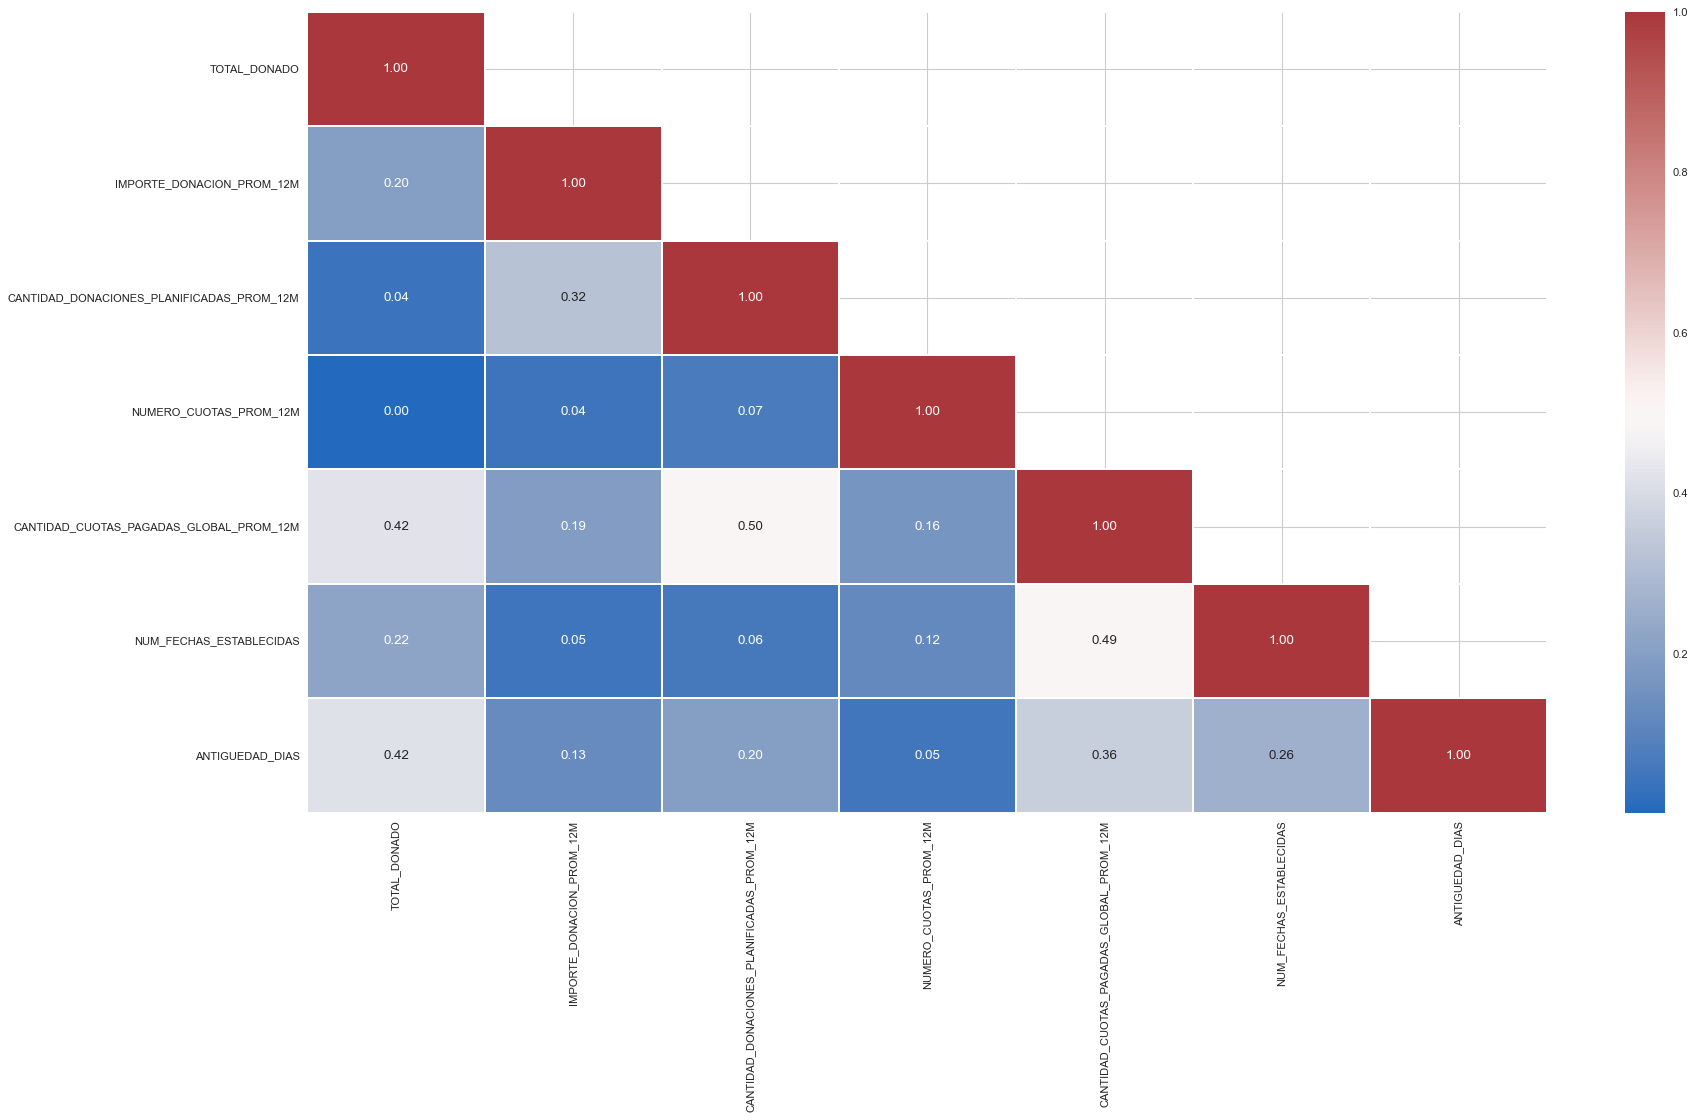

In [226]:
df_correlacion = df_consolidado_final[lista_variables]
print(f"Nro variables: {df_correlacion.shape[1] - 1}")
corr = df_correlacion.drop(columns=['CONTACTO_ID_COMPLETO']).corr(method='pearson').abs()

# Creamos una mascara para ver la correlacion en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# Mostramos la matriz de correlacion
plt.figure(figsize=(25,13), dpi = 80)
sns.heatmap(corr, mask = mask, annot=True, cmap='vlag', fmt='.2f', linewidths=0.2)
plt.show()

In [227]:
df_consolidado_final_limpio = df_consolidado_final[lista_variables]

# Resumen Data
#print(f'Nro Clientes: {df_consolidado_final_limpio["CONTACTO_ID_COMPLETO"].nunique():,}')
print(f'Nro Columnas: {df_consolidado_final_limpio.shape[1]:,}')
print(f'Nro Filas: {df_consolidado_final_limpio.shape[0]:,}')
df_consolidado_final_limpio.head(3)

Nro Columnas: 8
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25


In [228]:
revision_missings(df_consolidado_final_limpio)

,COLUMNA,NRO_NULL,%_NULL
0,CONTACTO_ID_COMPLETO,0,0.0%
1,TOTAL_DONADO,0,0.0%
2,IMPORTE_DONACION_PROM_12M,16492,43.89%
3,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,16492,43.89%
4,NUMERO_CUOTAS_PROM_12M,16492,43.89%
5,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,16492,43.89%
6,NUM_FECHAS_ESTABLECIDAS,0,0.0%
7,ANTIGUEDAD_DIAS,0,0.0%


In [229]:
#df_consolidado_final_limpio = df_consolidado_final_limpio[df_consolidado_final_limpio['ANTIGUEDAD_PRIMER_DONACION'].notna()]

df_consolidado_final_limpio = df_consolidado_final_limpio.fillna(0)

# Resumen Data
#print(f'Nro Clientes: {df_consolidado_final_limpio["CONTACTO_ID_COMPLETO"].nunique():,}')
print(f'Nro Columnas: {df_consolidado_final_limpio.shape[1]:,}')
print(f'Nro Filas: {df_consolidado_final_limpio.shape[0]:,}')
df_consolidado_final_limpio.head(3)

Nro Columnas: 8
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25


In [230]:
revision_missings(df_consolidado_final_limpio)

,COLUMNA,NRO_NULL,%_NULL
0,CONTACTO_ID_COMPLETO,0,0.0%
1,TOTAL_DONADO,0,0.0%
2,IMPORTE_DONACION_PROM_12M,0,0.0%
3,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0,0.0%
4,NUMERO_CUOTAS_PROM_12M,0,0.0%
5,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0,0.0%
6,NUM_FECHAS_ESTABLECIDAS,0,0.0%
7,ANTIGUEDAD_DIAS,0,0.0%


In [231]:
# Describe General
df_consolidado_final_limpio.drop(columns=['CONTACTO_ID_COMPLETO']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99,1.00
TOTAL_DONADO,-200.00,0.00,20.00,40.00,75.00,120.00,195.00,285.00,420.00,705.00,"1,115.00","2,052.90","30,600.00"
IMPORTE_DONACION_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,15.00,30.00,35.00,60.00,"3,000.00"
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00,12.00,15.00,17.00,17.00
NUMERO_CUOTAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,12.00
CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,7.00,11.00,34.00,358.00
NUM_FECHAS_ESTABLECIDAS,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,3.00,9.00
ANTIGUEDAD_DIAS,"-2,194.00",44.00,138.00,247.30,353.00,497.00,666.00,866.00,"1,037.00","1,225.00","1,312.00","1,480.29","1,595.00"


#### 03.2. Limpieza de Outliers

In [232]:
# Describe General
df_consolidado_final_limpio.drop(columns=['CONTACTO_ID_COMPLETO']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
TOTAL_DONADO,-200.00,0.00,20.00,40.00,75.00,120.00,195.00,285.00,420.00,705.00,"30,600.00"
IMPORTE_DONACION_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,15.00,30.00,"3,000.00"
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00,12.00,17.00
NUMERO_CUOTAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00
CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,7.00,358.00
NUM_FECHAS_ESTABLECIDAS,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,9.00
ANTIGUEDAD_DIAS,"-2,194.00",44.00,138.00,247.30,353.00,497.00,666.00,866.00,"1,037.00","1,225.00","1,595.00"


In [233]:
# Solo Limite Inferior
df_consolidado_final_limpio.drop(columns=['CONTACTO_ID_COMPLETO']).quantile([.0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1]).transpose()

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
TOTAL_DONADO,-200.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
IMPORTE_DONACION_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NUMERO_CUOTAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NUM_FECHAS_ESTABLECIDAS,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
ANTIGUEDAD_DIAS,"-2,194.00",5.00,9.00,12.00,16.00,20.00,24.00,28.00,32.00,38.00,44.00


In [234]:
# Solo Limite Superior
df_consolidado_final_limpio.drop(columns=['CONTACTO_ID_COMPLETO']).quantile([.9, .91, .92, .93, .94, .95, .96, .97, .98, .99, 1]).transpose()

,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
TOTAL_DONADO,705.00,760.00,800.00,900.00,990.00,"1,115.00","1,225.00","1,355.00","1,560.00","2,052.90","30,600.00"
IMPORTE_DONACION_PROM_12M,30.00,30.00,35.00,35.00,35.00,35.00,40.00,47.50,50.00,60.00,"3,000.00"
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,12.00,13.00,13.00,14.00,14.00,15.00,15.00,16.00,16.00,17.00,17.00
NUMERO_CUOTAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,12.00
CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,7.00,8.00,8.00,9.00,10.00,11.00,12.00,16.00,24.00,34.00,358.00
NUM_FECHAS_ESTABLECIDAS,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,9.00
ANTIGUEDAD_DIAS,"1,225.00","1,240.00","1,256.00","1,271.00","1,288.00","1,312.00","1,342.00","1,374.00","1,425.00","1,480.29","1,595.00"


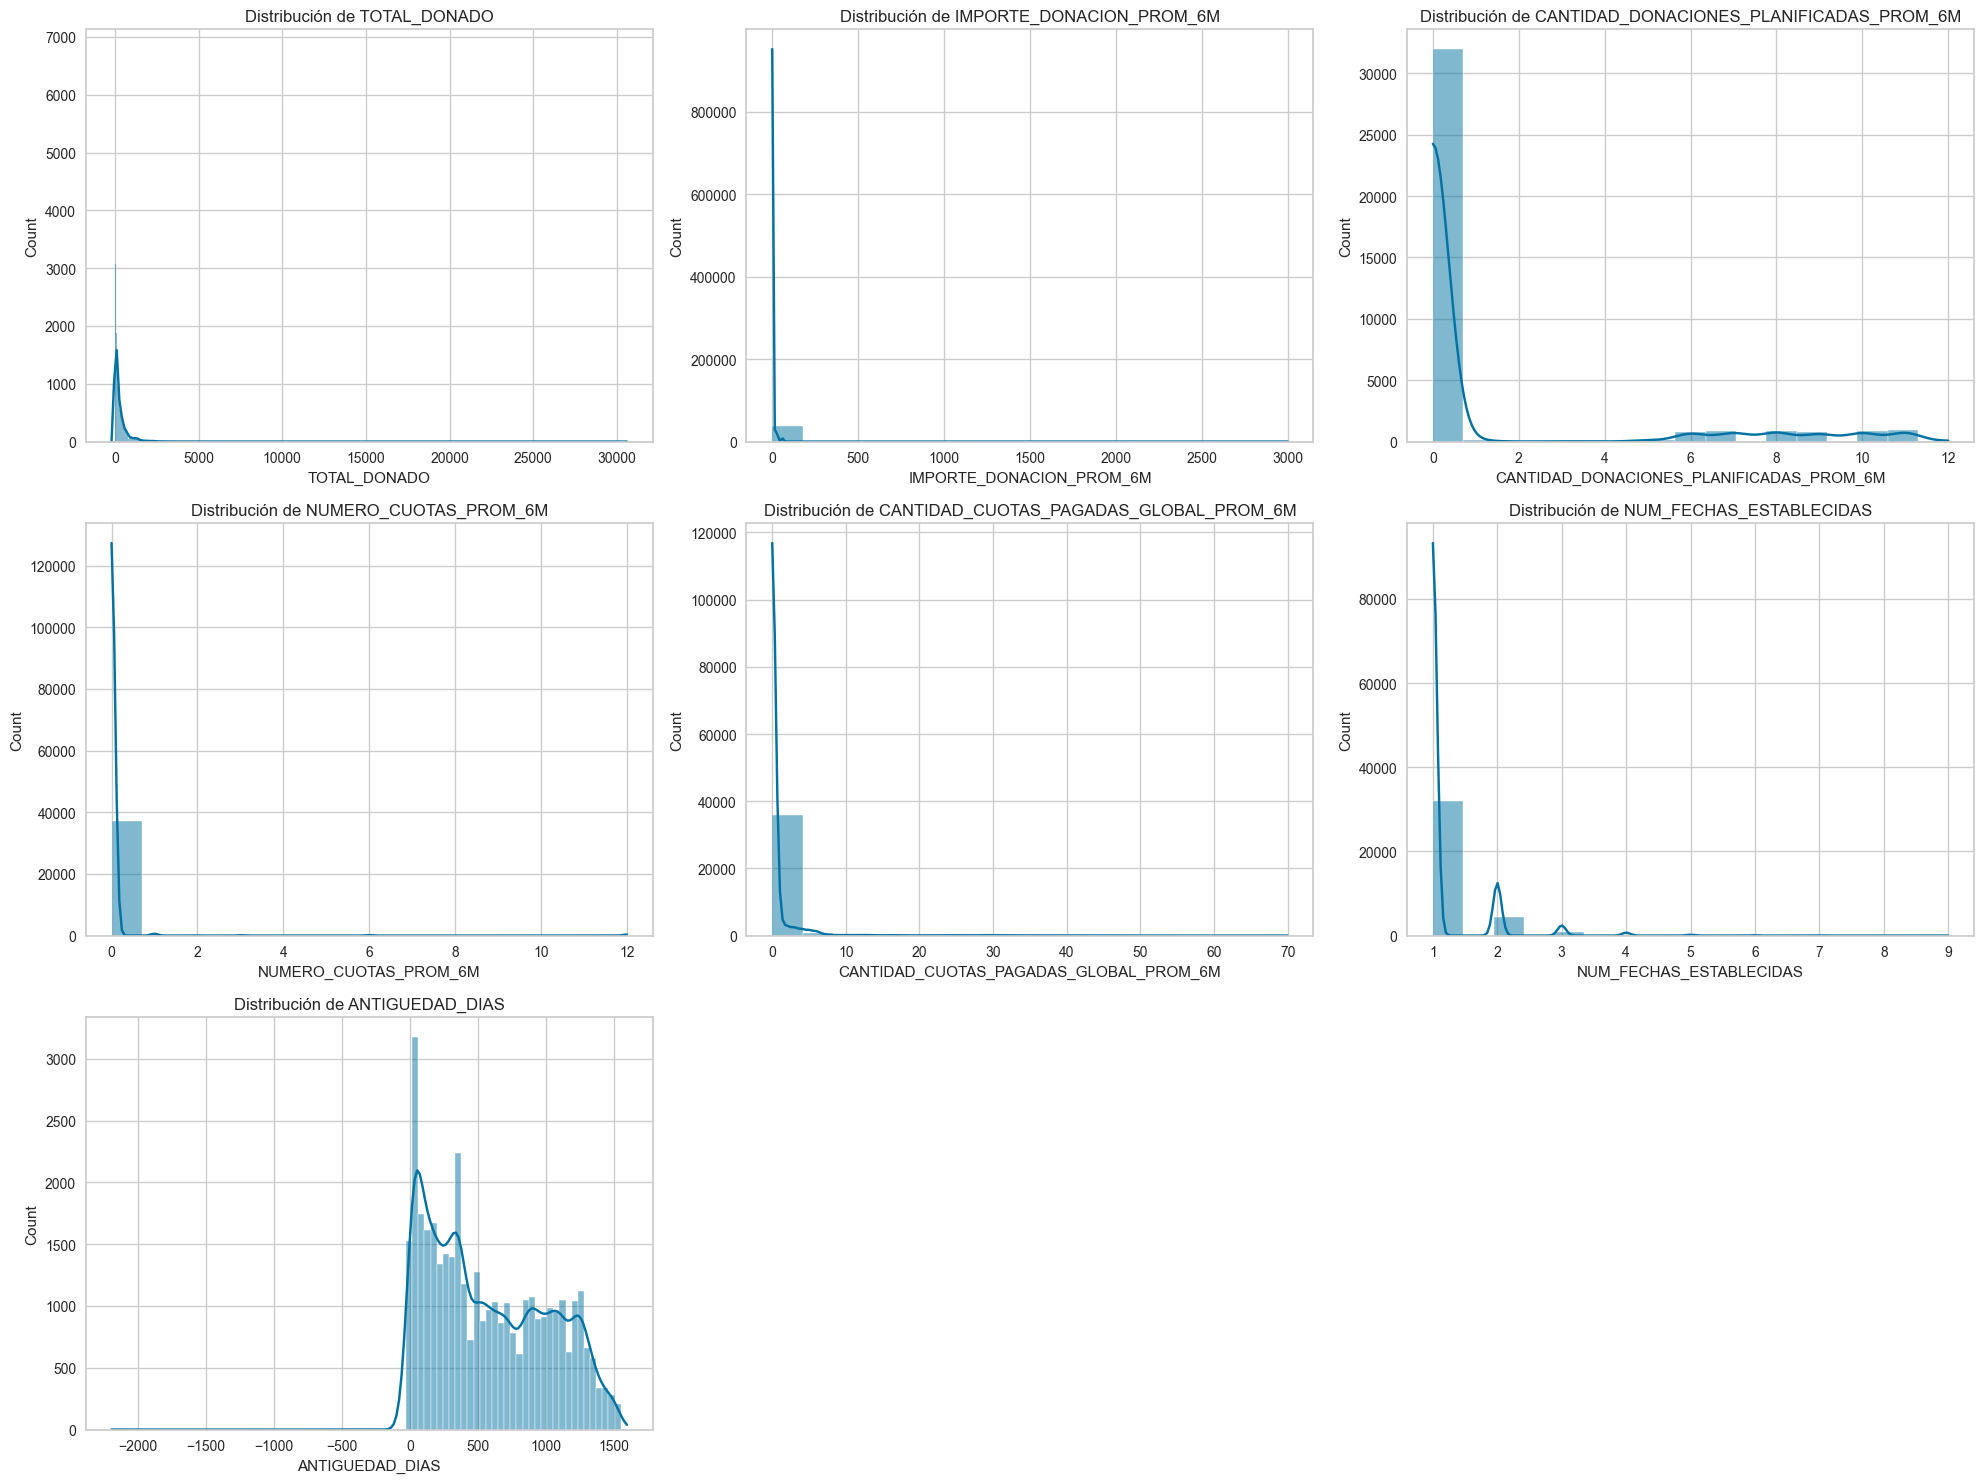

In [166]:
# Antes de limpiar
visualizar_kde(df_consolidado_final_limpio, excluir_columnas=['CONTACTO_ID_COMPLETO'], num_columnas=3, figsize=(20, 5))

In [236]:
limitar_por_izquierda(df_consolidado_final_limpio, 'TOTAL_DONADO', 0.01)

limitar_por_derecha(df_consolidado_final_limpio, 'TOTAL_DONADO', 0.99)
limitar_por_derecha(df_consolidado_final_limpio, 'IMPORTE_DONACION_PROM_12M', 0.99)

limitar_por_derecha(df_consolidado_final_limpio, 'NUM_FECHAS_ESTABLECIDAS', 0.99)
limitar_por_izquierda(df_consolidado_final_limpio, 'ANTIGUEDAD_DIAS', 0.01)

,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25
3,003UX00000I2VWoYAN,0.00,30.00,5.00,0.00,0.00,1,25
4,003UX00000I2PGCYA3,0.00,30.00,6.00,0.00,0.00,1,25
...,...,...,...,...,...,...,...,...
37567,0031R00002DPHMoQAP,20.00,20.00,7.00,0.00,1.00,1,18
37568,0031R00002BfEPJQA3,"1,140.00",0.00,0.00,0.00,0.00,1,554
37569,0031R0000283xI1QAI,60.00,0.00,0.00,0.00,0.00,1,182
37570,0031R000020sFAXQA2,0.00,20.00,5.00,0.00,0.00,1,27


In [237]:
# Describe General
df_consolidado_final_limpio.drop(columns=['CONTACTO_ID_COMPLETO']).quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]).transpose()

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
TOTAL_DONADO,0.00,0.00,20.00,40.00,75.00,120.00,195.00,285.00,420.00,705.00,"2,050.84"
IMPORTE_DONACION_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,15.00,30.00,60.00
CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00,12.00,17.00
NUMERO_CUOTAS_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00
CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,7.00,358.00
NUM_FECHAS_ESTABLECIDAS,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00
ANTIGUEDAD_DIAS,5.00,44.00,138.00,247.30,353.00,497.00,666.00,866.00,"1,037.00","1,225.00","1,595.00"


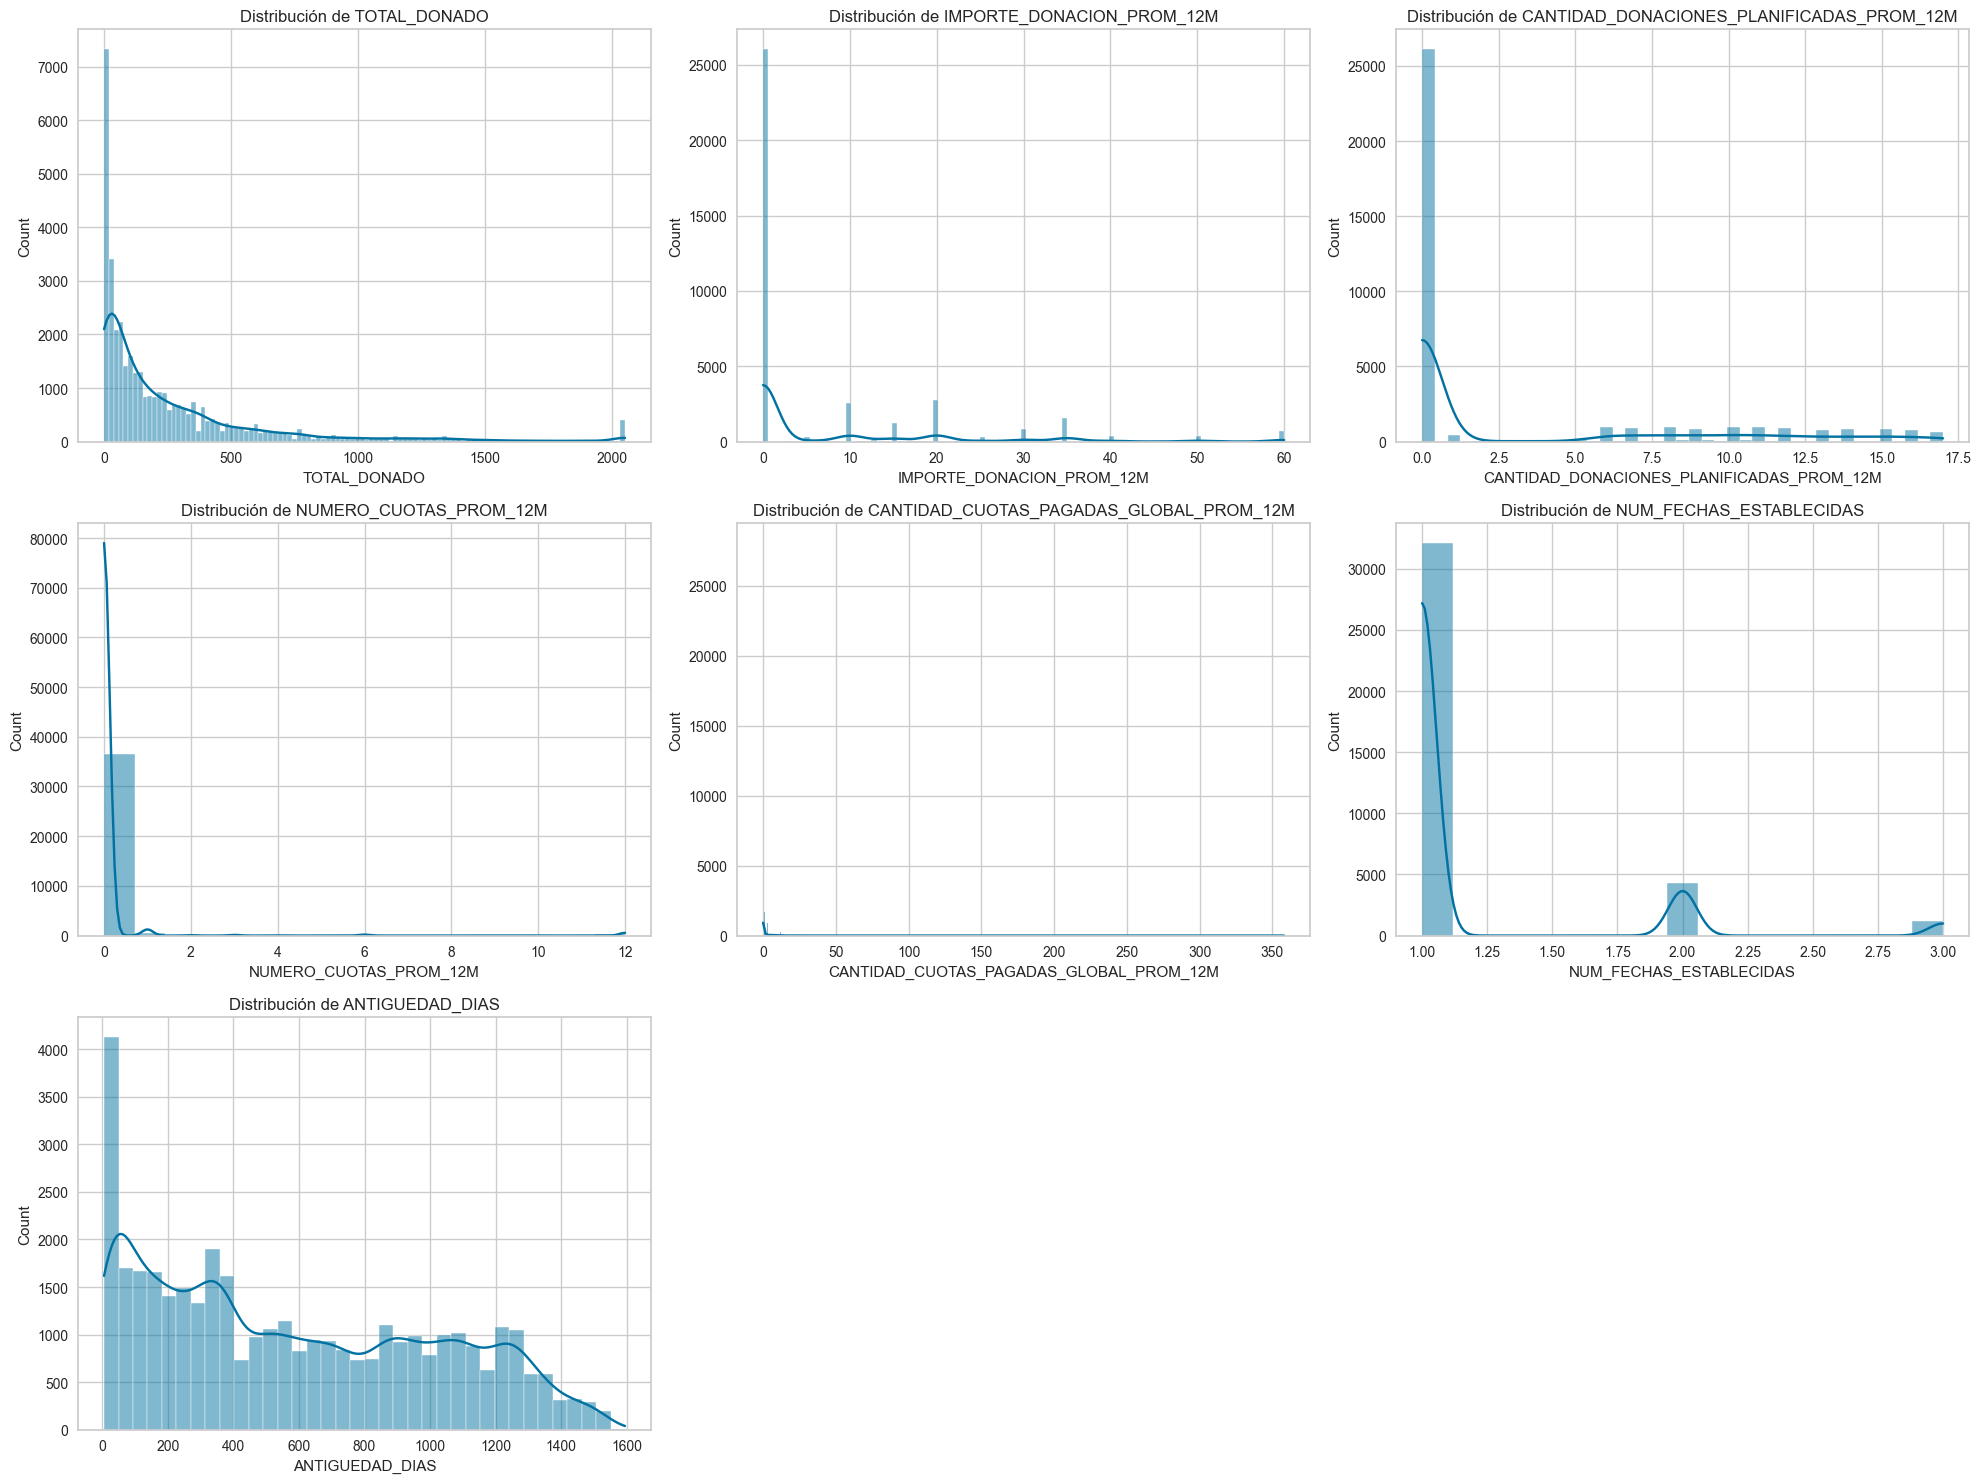

In [238]:
#visualizar_kde(df_consolidado_final_limpio, excluir_columnas=['CONTACTO_ID_COMPLETO'], num_columnas=3, figsize=(20, 5))

#### 03.3. Modelo de K-Means

In [239]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [240]:
# Resumen Data
print(f'Nro Clientes: {df_consolidado_final_limpio["CONTACTO_ID_COMPLETO"].nunique():,}')
print(f'Nro Columnas: {df_consolidado_final_limpio.shape[1]:,}')
print(f'Nro Filas: {df_consolidado_final_limpio.shape[0]:,}')
df_consolidado_final_limpio.head(3)

Nro Clientes: 37,572
Nro Columnas: 8
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25


In [241]:
revision_missings(df_consolidado_final_limpio)

,COLUMNA,NRO_NULL,%_NULL
0,CONTACTO_ID_COMPLETO,0,0.0%
1,TOTAL_DONADO,0,0.0%
2,IMPORTE_DONACION_PROM_12M,0,0.0%
3,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,0,0.0%
4,NUMERO_CUOTAS_PROM_12M,0,0.0%
5,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,0,0.0%
6,NUM_FECHAS_ESTABLECIDAS,0,0.0%
7,ANTIGUEDAD_DIAS,0,0.0%


In [242]:
df_ml = df_consolidado_final_limpio.copy()

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los colores más saturados
barra_color = "#5f5fff"  # Más saturado que #7f7fff
linea_color = "#11117e"  # Más saturado que #2525ff

# Crear el histograma con la distribución y KDE
sns.histplot(df_ml['ANTIGUEDAD_DIAS'], bins=30, kde=True, color=barra_color, line_kws={'color': linea_color})

# Personalización
plt.title("ANTIGUEDAD_DIAS", fontsize=14, fontweight="bold")
plt.xlabel("Valores", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)  # Cambiar "Densidad" a "Frecuencia"
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

KeyError: 'ANTIGUEDAD_DIAS'

In [243]:
df_ml_scaled = df_ml.copy()

# Seleccionar las columnas a escalar (todas excepto 'CONTACTO_ID_COMPLETO')
columns_to_scale = df_ml.columns[df_ml.columns != 'CONTACTO_ID_COMPLETO']

# Aplicar RobustScaler
robust_scaler = RobustScaler()
#scaler = StandardScaler()
df_ml_scaled[columns_to_scale] = robust_scaler.fit_transform(df_ml_scaled[columns_to_scale])

# Aplicar MinMaxScaler después de RobustScaler
minmax_scaler = MinMaxScaler()
df_ml_scaled[columns_to_scale] = minmax_scaler.fit_transform(df_ml_scaled[columns_to_scale])

#R esumen Data
print(f'Nro Clientes: {df_ml_scaled["CONTACTO_ID_COMPLETO"].nunique():,}')
print(f'Nro Columnas: {df_ml_scaled.shape[1]:,}')
print(f'Nro Filas: {df_ml_scaled.shape[0]:,}')
df_ml_scaled.head(5)

Nro Clientes: 37,572
Nro Columnas: 8
Nro Filas: 37,572


,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,003UX00000I2dSlYAJ,0.00,0.08,0.35,0.00,0.00,0.00,0.01
1,003UX00000I2bSXYAZ,0.00,0.33,0.35,0.00,0.00,0.00,0.01
2,003UX00000I2VWpYAN,0.00,0.33,0.35,0.00,0.00,0.00,0.01
3,003UX00000I2VWoYAN,0.00,0.50,0.29,0.00,0.00,0.00,0.01
4,003UX00000I2PGCYA3,0.00,0.50,0.35,0.00,0.00,0.00,0.01


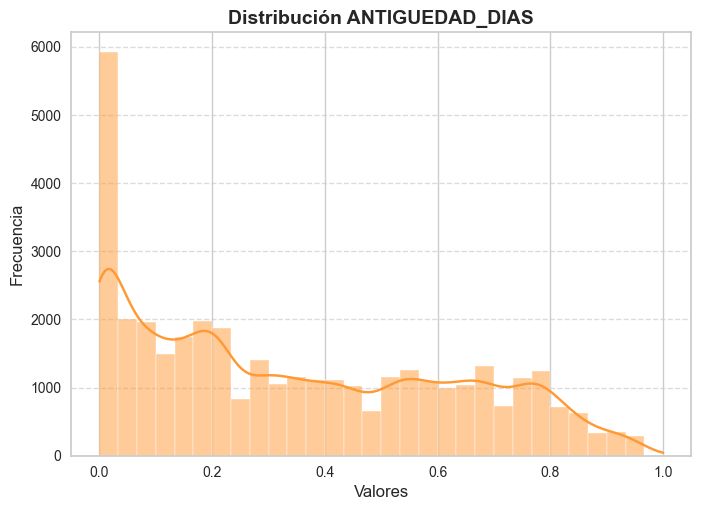

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los colores más saturados
barra_color = "#FF9933"  # Más saturado que #7f7fff
linea_color = "#11117e"  # Más saturado que #2525ff

# Crear el histograma con la distribución y KDE
sns.histplot(df_ml_scaled['ANTIGUEDAD_DIAS'], bins=30, kde=True, color=barra_color, line_kws={'color': linea_color})

# Personalización
plt.title("Distribución ANTIGUEDAD_DIAS", fontsize=14, fontweight="bold")
plt.xlabel("Valores", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)  # Cambiar "Densidad" a "Frecuencia"
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [244]:
import umap

# Aplicamos UMAP
umap_reducer = umap.UMAP( n_neighbors=5,n_components=2,random_state=1)
data_umap = umap_reducer.fit_transform(df_ml_scaled[columns_to_scale])

In [245]:
# Convertimos los resultados en un DataFrame para facilitar la visualización
umap_df = pd.DataFrame(data_umap, columns=['UMAP1', 'UMAP2'])

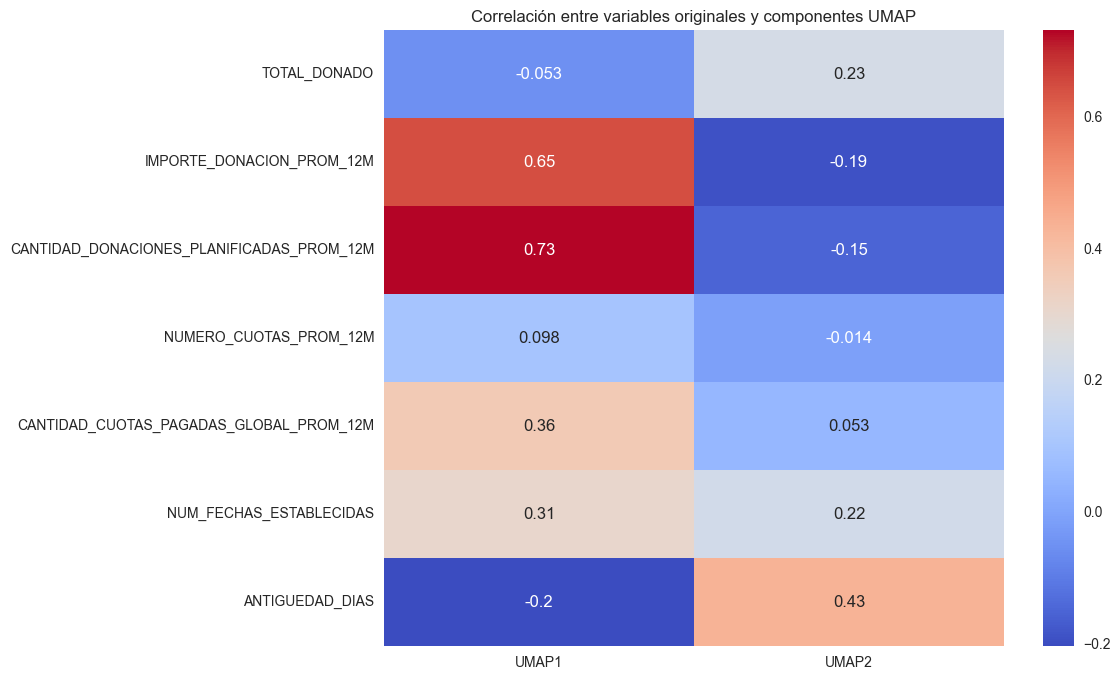

In [246]:
# Concatenamos las variables originales y las componentes UMAP
combined_df = pd.concat([df_ml_scaled[columns_to_scale].reset_index(drop=True), umap_df], axis=1)

# Calculamos la correlación entre las variables originales y las componentes UMAP
corr_matrix = combined_df.corr().loc[columns_to_scale, ['UMAP1', 'UMAP2']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables originales y componentes UMAP')
plt.show()

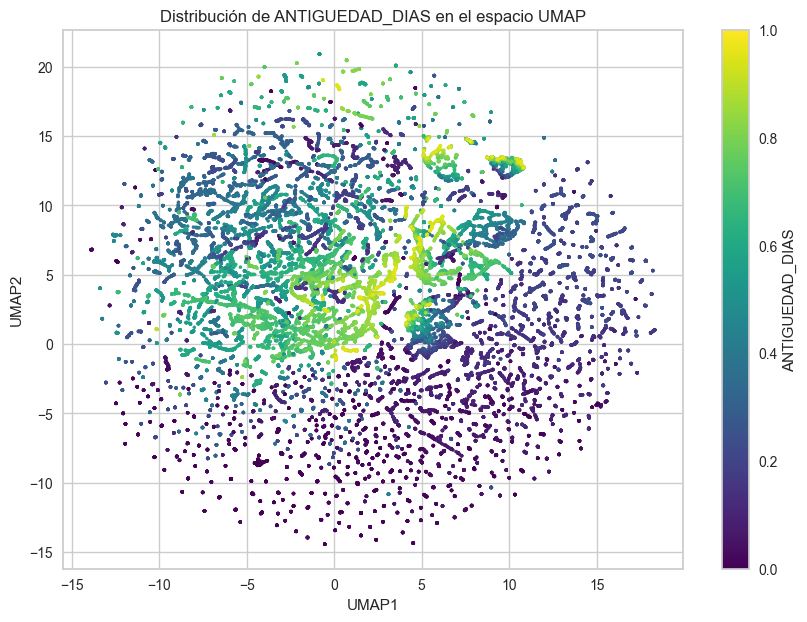

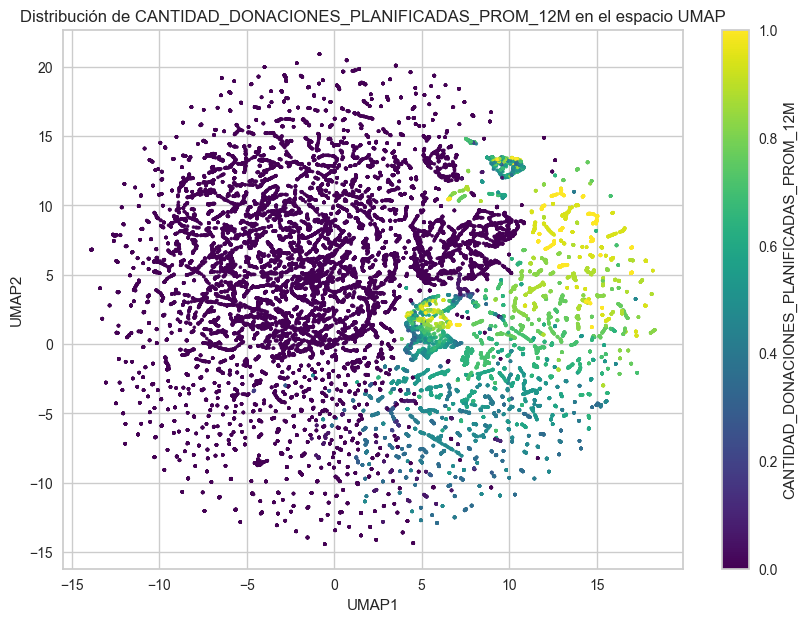

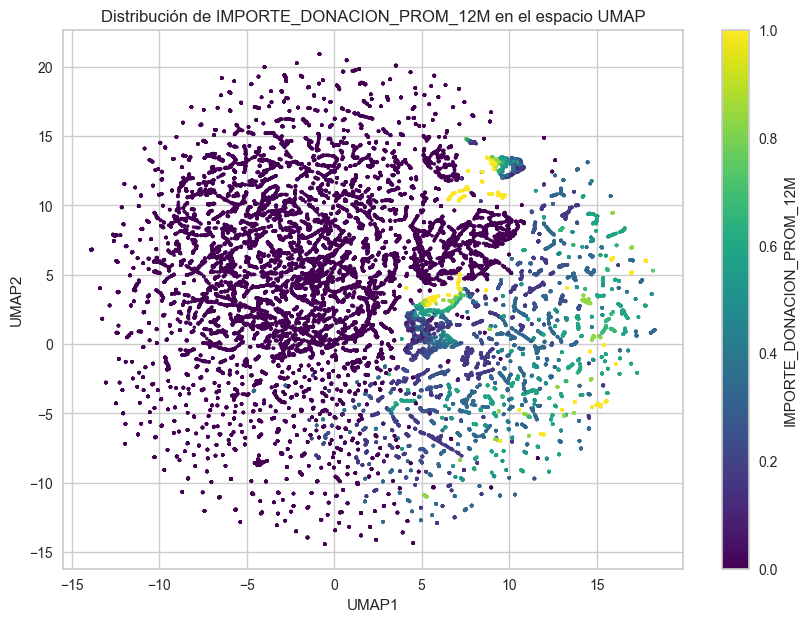

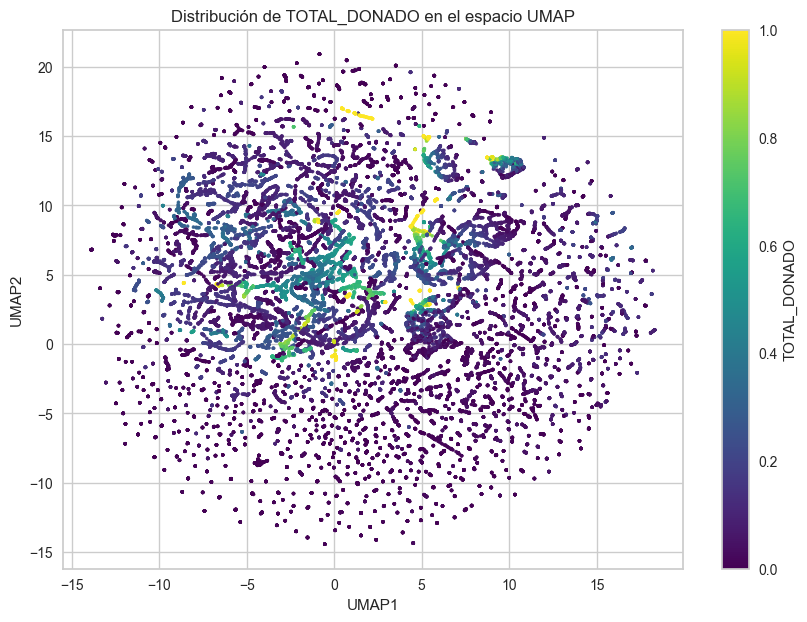

In [247]:
# Seleccionamos las variables más correlacionadas con UMAP1 y UMAP2
top_vars_umap1 = corr_matrix['UMAP1'].abs().sort_values(ascending=False).head(2).index
top_vars_umap2 = corr_matrix['UMAP2'].abs().sort_values(ascending=False).head(2).index

# Función para visualizar la distribución
def plot_umap_with_variable(variable):
    plt.figure(figsize=(10, 7))
    plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=df_ml_scaled[variable], cmap='viridis', s=5)
    plt.colorbar(label=variable)
    plt.title(f'Distribución de {variable} en el espacio UMAP')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()

# Visualizamos las variables más influyentes
for var in top_vars_umap1.union(top_vars_umap2):
    plot_umap_with_variable(var)

In [248]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

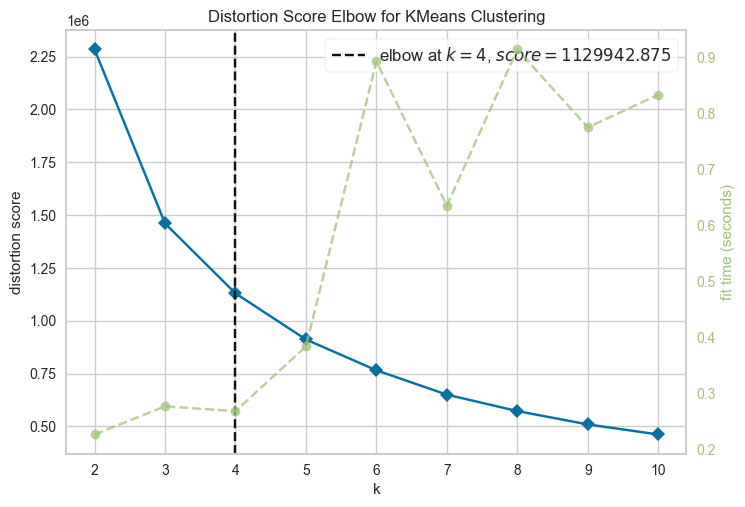

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [249]:
# Inicializar el modelo de KMeans
model = KMeans(n_init=10, random_state=0, max_iter=150, init='k-means++', algorithm='elkan')

# Inicializar el visualizador del método del codo con el rango de clusters
visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)

# Ajustar el visualizador con tus datos (excluyendo 'CODIGO_CLIENTE')
visualizer.fit(data_umap)  

# Visualizar el gráfico del codo
visualizer.show()

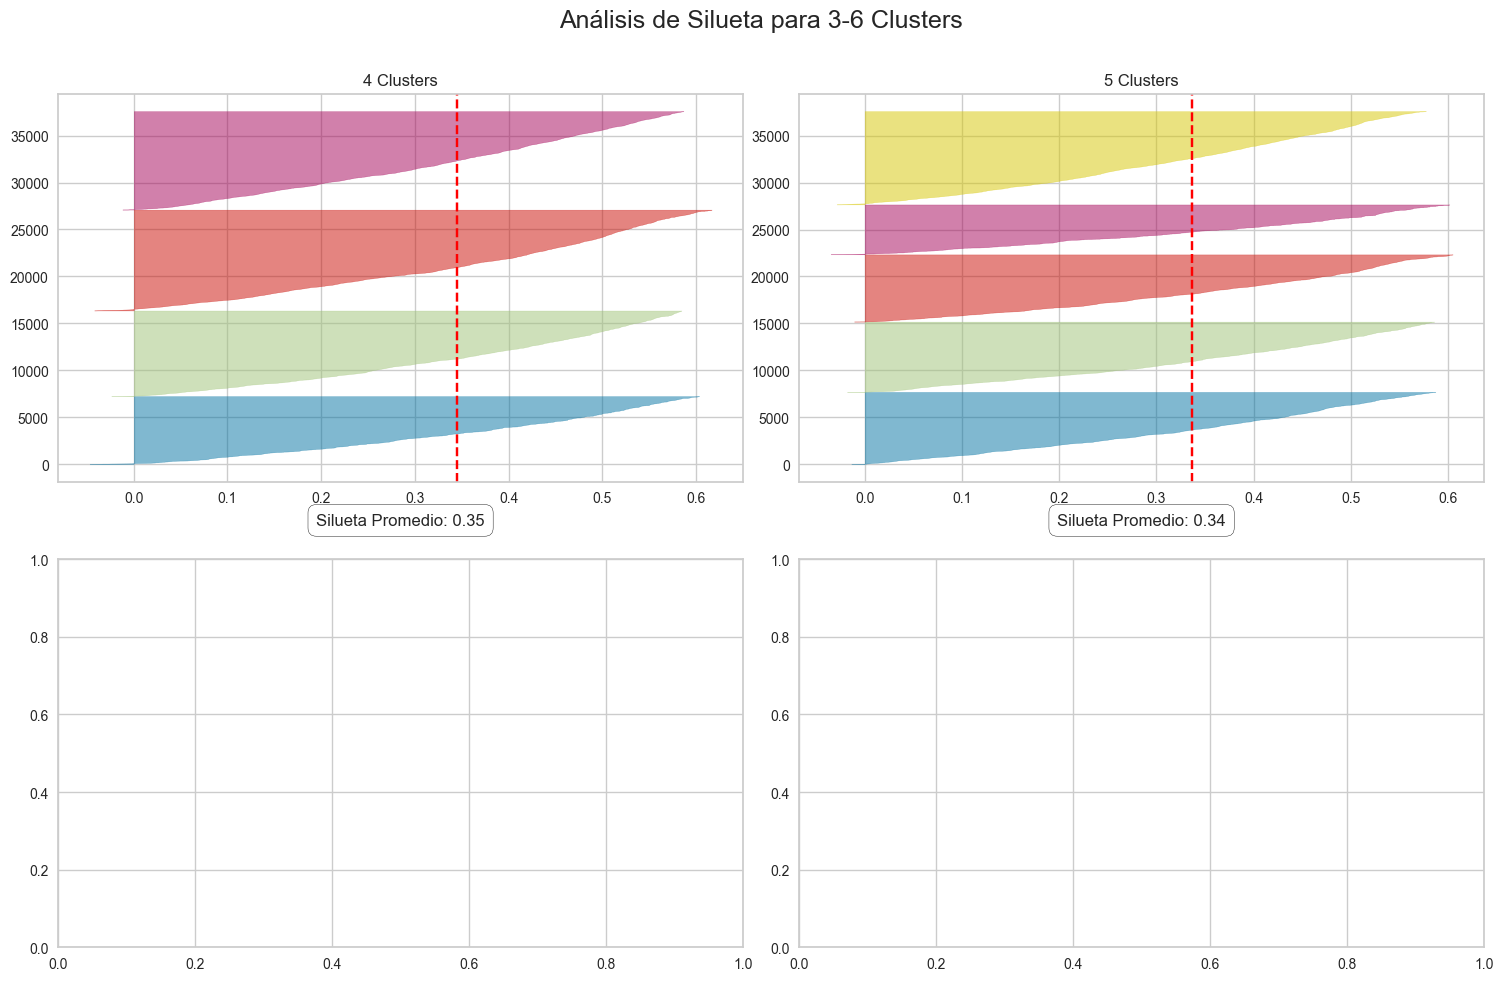

In [262]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

# Parámetros
num_clusters_min = 4
num_clusters_max = 5

# Configurar el gráfico con subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # Ajusta la figura para 4 subplots (2 filas, 2 columnas)
fig.suptitle('Análisis de Silueta para 3-6 Clusters', size=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta para dejar espacio para el título

# Bucle para crear el visualizador de silueta para diferentes números de clusters
for i, num_clusters in enumerate(range(num_clusters_min, num_clusters_max + 1)):
    # Crear instancia de KMeans para el número actual de clusters
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
    
    # Crear instancia de SilhouetteVisualizer con la instancia de KMeans
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[i // 2][i % 2])
    
    # Ajustar el visualizador
    visualizer.fit(data_umap)
    
    # Extraer el puntaje de silueta promedio
    silhouette_score = visualizer.silhouette_score_
    
    # Configurar título y puntaje de silueta para cada subplot
    ax[i // 2][i % 2].set_title(f'{num_clusters} Clusters')
    ax[i // 2][i % 2].text(0.5, -0.1, f'Silueta Promedio: {silhouette_score:.2f}', 
                           horizontalalignment='center', 
                           verticalalignment='center', 
                           transform=ax[i // 2][i % 2].transAxes, 
                           fontsize=12, 
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')) 

# Ajustar el espacio entre subplots
plt.subplots_adjust(hspace=0.2)

# Ajustar la visualización
plt.show()

In [251]:
#Paramatros
nro_clusters = 4

# Ajustar el modelo KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=nro_clusters, n_init=10, random_state=0, max_iter=100, init='k-means++', algorithm='elkan')
df_ml_scaled['Cluster'] = kmeans.fit_predict(data_umap)

In [252]:
columns_to_scale

Index(['TOTAL_DONADO', 'IMPORTE_DONACION_PROM_12M',
       'CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M', 'NUMERO_CUOTAS_PROM_12M',
       'CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M', 'NUM_FECHAS_ESTABLECIDAS',
       'ANTIGUEDAD_DIAS'],
      dtype='object')

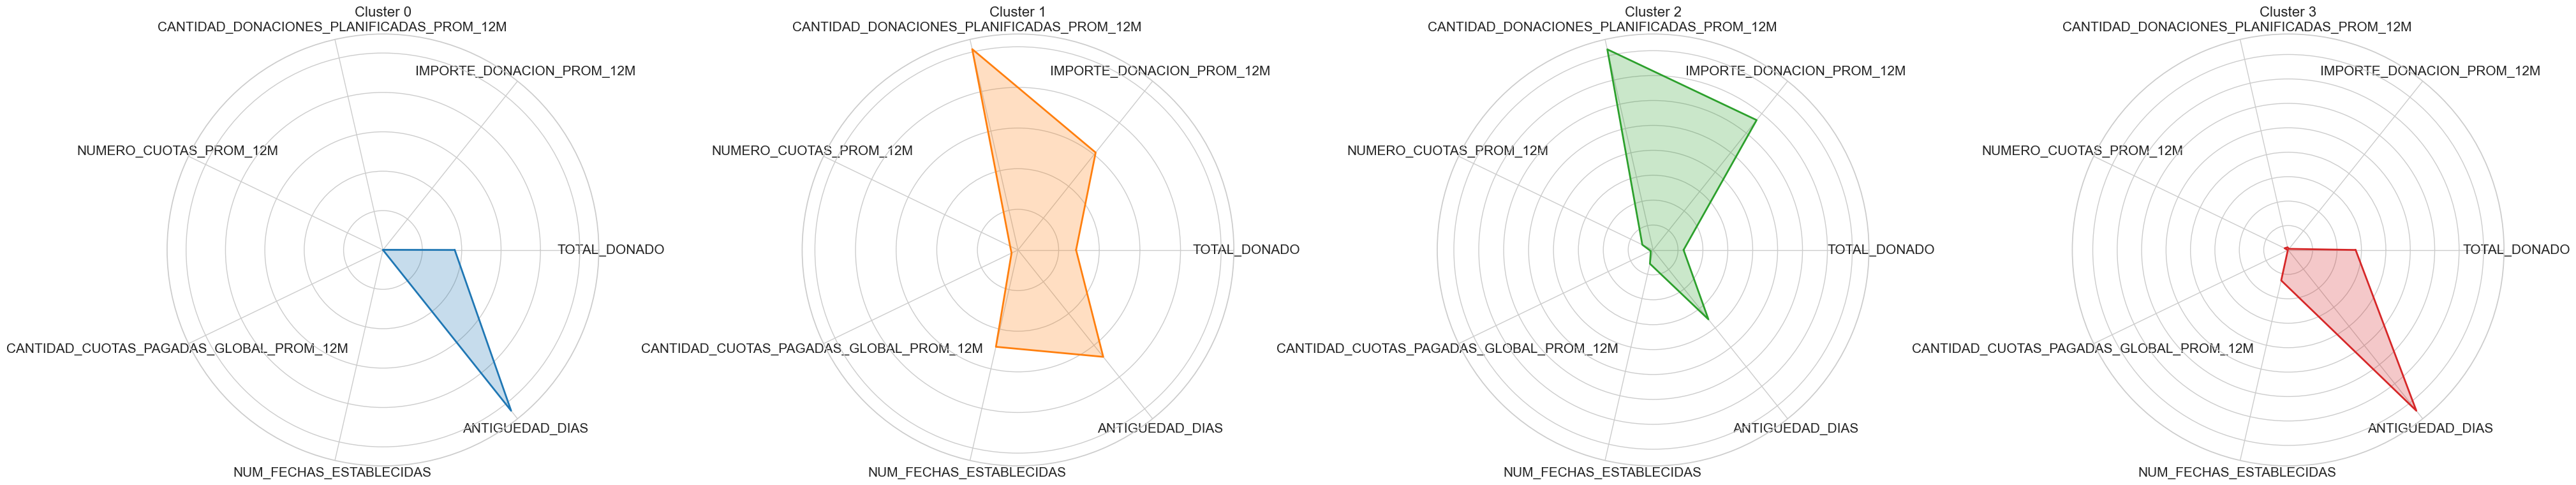

In [253]:
# Número de características 
num_vars = len(columns_to_scale)

# Calcular el promedio de cada característica por cluster
cluster_means = df_ml_scaled.groupby('Cluster')[columns_to_scale].mean()

# Configurar el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Cerrar el gráfico de radar
cluster_means = cluster_means.values
cluster_means = np.concatenate((cluster_means, cluster_means[:, [0]]), axis=1)
angles += angles[:1]

# Colores para los clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Inicializar la figura con subgráficos (ajustar el tamaño aquí)
fig, axs = plt.subplots(1, len(cluster_means), figsize=(40, 8), subplot_kw=dict(polar=True))

# Crear el gráfico de radar para cada cluster
for i in range(len(cluster_means)):
    # Dibujar el cluster actual
    axs[i].fill(angles, cluster_means[i], color=colors[i % len(colors)], alpha=0.25)
    axs[i].plot(angles, cluster_means[i], color=colors[i % len(colors)], linewidth=2)
    
    # Configurar etiquetas
    axs[i].set_xticks(angles[:-1])
    axs[i].set_xticklabels(columns_to_scale, fontsize=15)  # Aumentar el tamaño de la fuente

    # Ocultar los valores en el gráfico
    axs[i].set_yticklabels([])  # Esto oculta las etiquetas de los valores en el eje radial
    
    axs[i].set_title(f'Cluster {i}', size=16)  # Ajustar el tamaño del título

# Ajustar el layout
plt.tight_layout()
plt.show()

#### 03.4. Importancia Variables

Precisión del modelo Random Forest: 0.9995


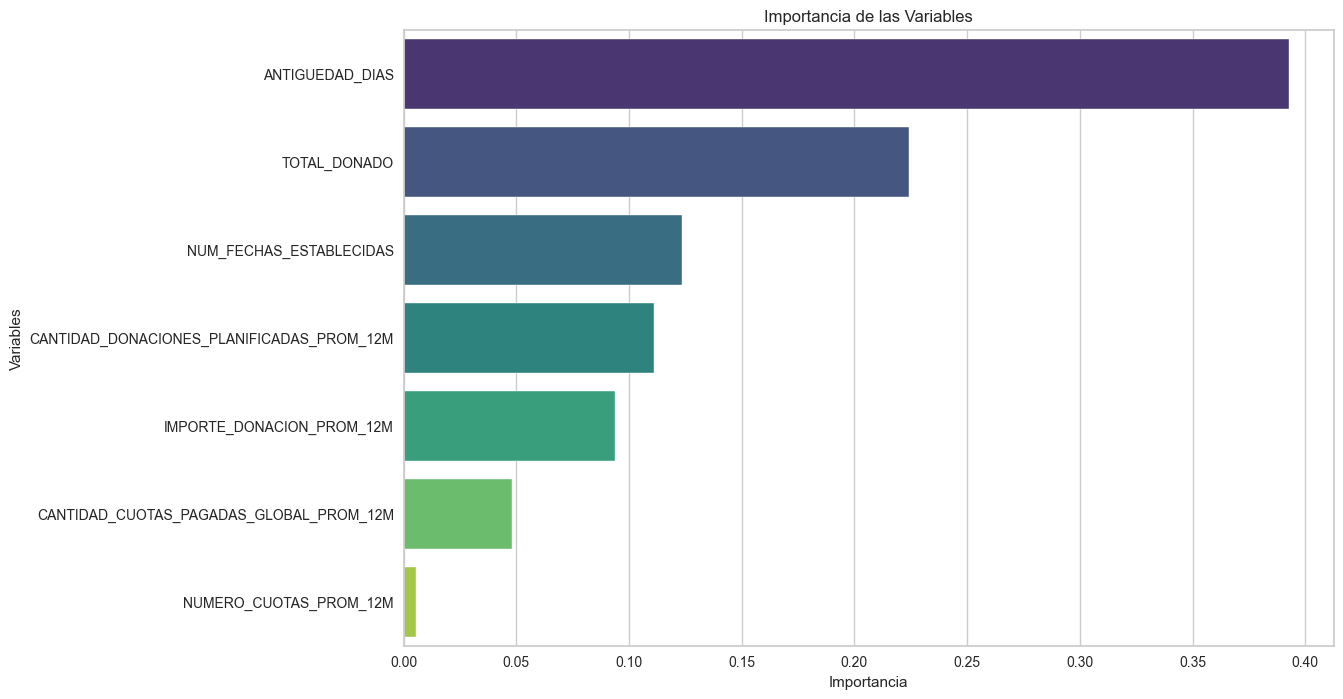

In [254]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Entrenar un modelo Random Forest para evaluar la importancia de las variables
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_ml_scaled[columns_to_scale], df_ml_scaled['Cluster'])

# Calcular la precisión del modelo
y_pred = rf.predict(df_ml_scaled[columns_to_scale])
accuracy = accuracy_score(df_ml_scaled['Cluster'], y_pred)
print(f'Precisión del modelo Random Forest: {accuracy:.4f}')

# Visualizar la importancia de las variables
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(y=df_ml_scaled[columns_to_scale].columns[indices], x=importances[indices], palette="viridis")
plt.title('Importancia de las Variables')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.show()

In [255]:
volumetria(df_ml_scaled, 'Cluster', 1)

,Cluster,Cantidad,% Total,% Acumulado
0,0,10462,27.85,27.85
1,1,10812,28.78,56.62
2,2,7362,19.59,76.22
3,3,8936,23.78,100.00


In [258]:
df_final = df_ml.merge(df_ml_scaled[['CONTACTO_ID_COMPLETO', 'Cluster']], how='inner', on = ['CONTACTO_ID_COMPLETO'])

df_final

,CONTACTO_ID_COMPLETO,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS,Cluster
0,003UX00000I2dSlYAJ,0.00,5.00,6.00,0.00,0.00,1,25,2
1,003UX00000I2bSXYAZ,0.00,20.00,6.00,0.00,0.00,1,25,2
2,003UX00000I2VWpYAN,0.00,20.00,6.00,0.00,0.00,1,25,2
3,003UX00000I2VWoYAN,0.00,30.00,5.00,0.00,0.00,1,25,2
4,003UX00000I2PGCYA3,0.00,30.00,6.00,0.00,0.00,1,25,2
...,...,...,...,...,...,...,...,...,...
37567,0031R00002DPHMoQAP,20.00,20.00,7.00,0.00,1.00,1,18,1
37568,0031R00002BfEPJQA3,"1,140.00",0.00,0.00,0.00,0.00,1,554,0
37569,0031R0000283xI1QAI,60.00,0.00,0.00,0.00,0.00,1,182,2
37570,0031R000020sFAXQA2,0.00,20.00,5.00,0.00,0.00,1,27,0


In [259]:
df_agrupado_01 = df_final.groupby('Cluster').agg(
    NRO_CLIENTES=('CONTACTO_ID_COMPLETO', 'count'),
).reset_index()

df_agrupado_01

,Cluster,NRO_CLIENTES
0,0,10462
1,1,10812
2,2,7362
3,3,8936


In [260]:
df_agrupado_02 = df_final.drop(columns = ['CONTACTO_ID_COMPLETO']).groupby('Cluster').mean().reset_index()
df_agrupado_02

,Cluster,TOTAL_DONADO,IMPORTE_DONACION_PROM_12M,CANTIDAD_DONACIONES_PLANIFICADAS_PROM_12M,NUMERO_CUOTAS_PROM_12M,CANTIDAD_CUOTAS_PAGADAS_GLOBAL_PROM_12M,NUM_FECHAS_ESTABLECIDAS,ANTIGUEDAD_DIAS
0,0,373.93,0.03,0.01,0.00,0.00,1.00,835.22
1,1,293.09,18.39,8.62,0.26,6.32,1.49,539.92
2,2,62.74,10.00,3.51,0.14,0.92,1.03,146.63
3,3,283.34,0.17,0.09,0.10,0.26,1.13,674.23


In [ ]:
0: Donantes Inactivos
1: Donantes Comprometidos | Recurrentes | Alto valor 
2: Nuevos Donantes | Alto Potencial
3: Donantes Esporádicos

In [ ]:
df_final_01 = df_04.merge(df_final[['CUSTOMER_SK', 'Cluster']], how='inner', on = ['CUSTOMER_SK'])

# Crear un diccionario de mapeo para renombrar los clusters
mapeo_clusters = {
    0: 'ACT_00', 
    1: 'ACT_01', 
    2: 'ACT_02', 
    3: 'ACT_03', 
    4: 'N1_04'
}

# Aplicar el mapeo a la columna 'Cluster'
df_final_01['Cluster'] = df_final_01['Cluster'].map(mapeo_clusters)

#R esumen Data
print(f'Nro Clientes: {df_final_01["CUSTOMER_SK"].nunique():,}')
print(f'Nro Columnas: {df_final_01.shape[1]:,}')
print(f'Nro Filas: {df_final_01.shape[0]:,}')
df_final_01.head(5)

Nro Clientes: 1,528
Nro Columnas: 54
Nro Filas: 1,528


,CUSTOMER_SK,CANTIDAD_PRODUCTOS_ACTIVOS_TOTAL,CANTIDAD_PRODUCTOS_ACTIVOS_UNICOS,ANTIGUEDAD_CLIENTE_DIAS,MONTO_DESEMB_PROM_PR_COMERCIAL_ULT_12_MESES,MONTO_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,CANTIDAD_DESEMB_TOTAL_PR_COMERCIAL_ULT_12_MESES,DEUDA_TOTAL_COMERCIAL,SALDO_TOTAL_PROM_ACTIVAS_COMERCIAL_ULT_12MESES,SALDO_TOTAL_PROM_PASIVAS_COMERCIAL_ULT_12MESES,ACTIVAS_MARGEN_PROM_ULT_12M,PASIVAS_MARGEN_PROM_ULT_12M,CANTIDAD_ACTIVAS_SIS_FINANCIERO,CANTIDAD_INSTITUCIONES_FINANCIERAS,TOTAL_DESEMB_PR_SIST_FINANC,TOTAL_ADEUDADO_TC_SIST_FINANC,SALDO_TOTAL_ACTIVAS_COMERCIAL_ULT_12MESES,SUM_BP_BRRD_ULT_12M_CA,PROM_BP_BRRD_ULT_12M_CA,SUM_BP_BRRD_ULT_12M_CC,PROM_BP_BRRD_ULT_12M_CC,SUM_BP_BRRD_ULT_12M_CD,PROM_BP_BRRD_ULT_12M_CD,MAX_DIAS_ATRASO_PR,PROM_TRANS_ULT_12M_TUBANCO,PROM_TRANS_ULT_12M_APP,PROM_TRANS_ULT_12M_SAB,PROM_TRANS_ULT_12M_IVR,PROM_TRANS_ULT_12M_M960,PROM_TRANS_ULT_12M_TPAGO,PROM_TRANS_ULT_12M_ATM,PROM_TRANS_ULT_12M_POS,PROM_TRANS_ULT_12M_CAJA,PROM_MENS_ULT_24M_DEPOSITOS,PROM_MENS_LC_TARJETA_CREDITO_ULT_12M,CODIGO_CIU,CIU,CODIGO_SECTOR,SECTOR_ECONOMICO,SUM_GANANCIAS_12M,SUM_PROVISION_CONSTITUIDA_12M,SUM_COMISIONES_12M,PROM_SCORE_INTERNO,PROM_BALANCE_PR_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_TC_BANRESERVAS_12M_COMERCIAL,PROM_BALANCE_PR_COMPETENCIA_12M_COMERCIAL,PROM_BALANCE_TC_COMPETENCIA_12M_COMERCIAL,PROM_SOW_PRESTAMOS_12M_COMERCIAL,PROM_SOW_TC_12M_COMERCIAL,PROM_SOW_TOTAL_12M_COMERCIAL,INDES_ULT_6_MES,PROM_TRANS_ULT_12M_FISICOS,PROM_TRANS_ULT_12M_NO_FISICOS,Cluster
0,2851211,1,1,3553,NaN,NaN,NaN,NaN,"73,273.23",0.00,"7,133.48",0.00,5.00,2.00,0.00,"577,079.90",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0,0,0,0.00,9.50,0.00,NaN,"344,985.00","930,000.00",Servicios N. C. P.,O,"Otras actividades de servicios comunitarios, sociales y personales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.49,NaN,NaN,NaN,9.50,0.00,ACT_00
1,548918,2,2,3871,NaN,NaN,NaN,NaN,"31,916.65",0.00,711.38,"8,344.39",5.00,2.00,0.00,"39,416.00",NaN,"12,729,181.36","1,060,765.11",NaN,NaN,NaN,NaN,NaN,5.75,4.00,0.33,0,0,0,1.75,34.83,4.50,"332,107.12","59,332.00","950,004.00",Empleados (asalariados),P,"Actividades de los hogares en calidad de empleadores, actividades indiferenciadas de producción de bienes y servicios de los hogares para uso propio","101,332.83",580.48,"46,789.13",NaN,NaN,NaN,NaN,NaN,13.73,NaN,NaN,NaN,41.08,9.75,ACT_00
2,480465,3,3,3871,NaN,NaN,NaN,NaN,"212,086.11",22.44,"-5,934.02",40.12,15.00,6.00,"13,766,139.00","1,641,311.71",NaN,"44,272.67","3,689.39","24,125.86","8,041.95",NaN,NaN,NaN,0.08,0.00,0.00,0,0,0,0.00,103.25,0.33,"48,887.12","263,343.00","503,102.00",Venta de llantas de goma y tubos,G,Comercio al por mayor y al por menor,"-18,028.91","4,743.27","108,329.70",NaN,NaN,NaN,NaN,NaN,20.10,NaN,NaN,NaN,103.58,0.08,ACT_00
3,186465,7,4,3871,NaN,NaN,NaN,NaN,"12,221.35","10,220,109.66","2,373.75","11,448.82",8.00,3.00,"1,007,292.00","53,911.26",NaN,"740,747.78","25,543.03","2,677,444.93","223,120.41","120,036,172.57","5,001,507.19",NaN,2.83,31.25,0.00,0,0,0,7.67,19.00,1.92,"1,275,587.76","214,225.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales","175,103.79","8,954.94","63,502.15",NaN,NaN,NaN,NaN,NaN,53.55,NaN,NaN,NaN,28.59,34.08,ACT_02
4,1540579,7,3,3553,NaN,NaN,NaN,NaN,943.57,"2,656,071.49",38.80,993.98,9.00,3.00,"888,709.00","338,405.61",NaN,"182,489.26","26,069.89",NaN,NaN,"25,640,539.42","1,349,502.07",NaN,0.00,0.00,0.00,0,0,0,0.00,2.42,0.00,"2,071,641.57","197,507.00","740,000.00",Otras actividades empresariales,K,"Actividades inmobiliarias, alquiler y actividades empresariales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.95,NaN,NaN,NaN,2.42,0.00,ACT_00


In [105]:
df_estadisticos.to_clipboard(index=False)

### Data Final

In [151]:
df_final_01.groupby(['Cluster']).agg(
    RECUENTO = ('CUSTOMER_SK', 'count'),
).reset_index()

,Cluster,RECUENTO
0,ACT_00,612
1,ACT_01,398
2,ACT_02,518


In [ ]:
df_clusters.to_csv('Output/df_clusters_emp.csv', sep=";", index=False, encoding='LATIN-1')